# Lab Assignment Five: Wide and Deep Network Architectures

Team: Mike Wisniewski

In [1]:
import pandas as pd
import numpy as np
import warnings
import umap
import matplotlib.pyplot as plt
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from imblearn.under_sampling import RandomUnderSampler

# set display settings
pd.options.display.max_columns = 100
%matplotlib inline
warnings.filterwarnings('ignore')

## Dataset Selection

>Select a dataset similarly to lab one. That is, the dataset must be table data. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification, multi-class classification, or regression.

The dataset used for this excercise will be the bank and marketing dataset provided by UCI: https://archive.ics.uci.edu/ml/datasets/bank+marketing

The specific dataset used from the above source will be the bank-additional-full.csv which is a dataset with 41,188 examples and 20 features + 1 output.  This set differs from the original bank-full.csv by adding 3 additional features which are used to represent economic factors (which may or may not be useful).  The data within is dated from May 2008 to November 2010.  This data is from a Portuguese banking institution and was gathered as a result of marketing campaigns.  

I will not go into what each feature is specifically until we do feature engineering later.  However, to give a general overview of the data within, there are 4 main groups of data:

- Bank Client Data: this is personal data about the client like job, marital status, education, etc.
- Campaign Contact Data: this is information gained from the phone calls during the campaign about each client.  Examples include date of contact, type of communication, duration, etc.
- Previous Campaign Data: this is data gained from the phone calls during previous campaigns about each client.  Examples include previous days since last contact on a previous campaign, number of contacts with clients before current campaign, etc.
- Social and Economic factors: 3rd party data that was provided to assess the current economic health.  Examples include employment rate, consumer price index, and confidence
    
It is important that the above data was grouped in such a manner because it allows myself to create logical data combinations when I preform wide networks later.  Not all of the data above is useful which I will explain in a later section.  I do believe there is enough useful data to provide a decent analysis using wide and deep networks

The objective of this data is to assess whether the bank product would be subscribed to or not.  In other words, this was a campaign to gather interest in a new bank product put forth by the Potuguese institution (the business case)

In [2]:
# import dataset
df = pd.read_csv("bank-additional-full.csv", delimiter=";")

In [3]:
# preview dataset
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
# describe the dataset
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Preparation
>[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

The first step I take is to remove data that we know we won't need and to give justification:
- duration: per documentation in UCI it is recommended to take this out if using the data for predictive analytics.  I should only be used for benchmarking purposes (which we won't be doing).  Therefore we can discard
- month: this is the month of contact, which we can discard as this is not a time series analysis
- day_of_week: similar to month
- contact: this is medium of which communication happened.  There are only 2 values: landline and cellphone, both of which are the same thing and I would think have no bearing on the campaign output

In [5]:
# remove features not needed
cols_to_remove = ["duration", "month", "day_of_week", "contact"]

df = df.drop(cols_to_remove, axis=1)

The second step is to analyze the categoricals and identify missing data.  Missing data has been defined for us as "unknown".  Replace unknown with an infered value of "no" for binary features, but keep it as "unknown" for multi-categorical.  We can make the assumption that any binary data which contains null values will be defaulted to "No".  Typically, a failure to respond on a binary value generally means a no, so therefore I will be using this as an assumption to fill in this type of data.  We can not deduce the same for multi-categorical because multi-categorical, by nature, gives too many options to infer an "unknown" value.  We will preserve "unknown" as its own category for multi-categorical features as a failure to answer for multi-categorical can mean something tangible.

In [6]:
# identify unique values
print("Unique values for job:", df["job"].unique())
print("Unique values for marital:", df["marital"].unique())
print("Unique values for education:", df["education"].unique())
print("Unique values for default:", df["default"].unique())
print("Unique values for housing:", df["housing"].unique())
print("Unique values for loan:", df["loan"].unique())
print("Unique values for previous outcome:", df["poutcome"].unique())
print("Unique values for output variable:", df["y"].unique())

Unique values for job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values for marital: ['married' 'single' 'divorced' 'unknown']
Unique values for education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values for default: ['no' 'unknown' 'yes']
Unique values for housing: ['no' 'yes' 'unknown']
Unique values for loan: ['no' 'yes' 'unknown']
Unique values for previous outcome: ['nonexistent' 'failure' 'success']
Unique values for output variable: ['no' 'yes']


In [7]:
# replace unknown values with "no"
df.loc[df["default"] == "unknown", "default"] = "no"
df.loc[df["housing"] == "unknown", "housing"] = "no"
df.loc[df["loan"] == "unknown", "loan"] = "no"

# identify unique values
print("Unique values for job:", df["job"].unique())
print("Unique values for marital:", df["marital"].unique())
print("Unique values for education:", df["education"].unique())
print("Unique values for default:", df["default"].unique())
print("Unique values for housing:", df["housing"].unique())
print("Unique values for loan:", df["loan"].unique())
print("Unique values for previous outcome:", df["poutcome"].unique())
print("Unique values for output variable:", df["y"].unique())

Unique values for job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values for marital: ['married' 'single' 'divorced' 'unknown']
Unique values for education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values for default: ['no' 'yes']
Unique values for housing: ['no' 'yes']
Unique values for loan: ['no' 'yes']
Unique values for previous outcome: ['nonexistent' 'failure' 'success']
Unique values for output variable: ['no' 'yes']


The third step is to handle outliers for numerical and continuous features.  The only one of great concern that appears to have "outliers" is pdays - which states that 999 is used for clients which have not been previously contacted about any campaigns prior to this campaign.  I wish to convert 999 to 0, however we have records with 0 as the value for pdays - and the associated poutcome with 0 pdays is always a success, whereas the poutcome with pdays = 999 is nonexistent.  To handle this, I will change all of the 0 pdays to 0.5 days and all of the 999 days to 0.  I don't wish to null out the 999 days because I eventually will want to scale this column (which is not possible with null values).  So, I am opting for a substitution method instead of trying to infer these values.

Based on the dataset desciption above, pdays is the only numerical column that will need any outlier handling

In [8]:
# observe the dataset where pdays == 0
df[df["pdays"] == 0]

,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
25497,31,unemployed,single,professional.course,no,yes,no,1,0,1,success,-0.1,93.200,-42.0,4.120,5195.8,no
25996,35,management,married,university.degree,no,yes,yes,3,0,2,success,-0.1,93.200,-42.0,4.120,5195.8,no
30238,51,technician,married,professional.course,no,yes,no,1,0,1,success,-1.8,93.075,-47.1,1.365,5099.1,yes
30314,36,admin.,married,university.degree,no,yes,no,1,0,1,success,-1.8,93.075,-47.1,1.365,5099.1,yes
30417,30,admin.,single,university.degree,no,yes,no,1,0,1,success,-1.8,93.075,-47.1,1.365,5099.1,yes
30688,35,blue-collar,married,basic.6y,no,yes,no,1,0,1,success,-1.8,92.893,-46.2,1.344,5099.1,no
40360,48,admin.,married,university.degree,no,yes,yes,1,0,3,success,-1.7,94.027,-38.3,0.900,4991.6,yes
40364,27,student,single,university.degree,no,yes,no,1,0,3,success,-1.7,94.027,-38.3,0.900,4991.6,yes
40365,28,student,single,basic.9y,no,yes,no,1,0,1,success,-1.7,94.027,-38.3,0.900,4991.6,yes
40376,27,student,single,university.degree,no,yes,no,1,0,5,success,-1.7,94.027,-38.3,0.900,4991.6,no


In [9]:
# observe the dataset where pdays == 999
df[df["pdays"] == 999]

,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [10]:
# change records with pdays == 0 to pdays == 0.5
df.loc[df["pdays"] == 0, "pdays"] = 0.5

# change records with pdays == 999 to pdays == 0
df.loc[df["pdays"] == 999, "pdays"] = 0

The fourth step is to convert categorical features in such a manner where we preserve the original values of the categories, but create an entirely new set of numeric versions of the categoricals.  We preserve the original values because later we will be combining the qualitative values in each category when crossing the dataset.  I will be utilizing some of the lecture code for this section

In [11]:
# define categorical features
categorical_cols = ["job", "marital", "education", "poutcome", "default", "housing", "loan"]

# save each encoder in dictionary
encoders = dict()

# train all encoders
for col in categorical_cols:
    # integer encode strings that are features
    encoders[col] = LabelEncoder()
    df[col+'_int'] = encoders[col].fit_transform(df[col])
    
    
# define categorical features converted to int format
categorical_int_cols = [col + "_int" for col in categorical_cols]

The fifth step is to convert the no/yes output variable "y" into numeric binary columns.  This is important that we do not perform this similar exercise for our binary X features because when we cross combine columns later, the cross combinations expect strings, not integer values.  I kept in the original code the first time I went through this just to showcase that I had ran into this issue much later in the notebook when I tried cross combining.  Only our "y" output is converted to numeric.

In [12]:
# convert yes/no columns to int binary representations
df["y"].replace(to_replace="no", value=0, inplace=True)
df["y"].replace(to_replace="yes", value=1, inplace=True)
# df["default"].replace(to_replace="no", value=0, inplace=True)
# df["default"].replace(to_replace="yes", value=1, inplace=True)
# df["housing"].replace(to_replace="no", value=0, inplace=True)
# df["housing"].replace(to_replace="yes", value=1, inplace=True)
# df["loan"].replace(to_replace="no", value=0, inplace=True)
# df["loan"].replace(to_replace="yes", value=1, inplace=True)

# print("Unique values for default:", df["default"].unique())
# print("Unique values for housing:", df["housing"].unique())
# print("Unique values for loan:", df["loan"].unique())
# print("Unique values for output variable:", df["y"].unique())

The sixth step is to scale the datasets using a standard scaler.  I choose a standard scaler because I feel confident that I've handled outliers appropriately for this exercise so there is no need for a robust scaler.

In [13]:
# scale the numeric, continuous variables
numeric_cols = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

# initialize scaler
scaler = StandardScaler()

# scale numeric columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols].values)

#### Describe the dataset
After completing the above steps, our dataset is ready to begin the process of splitting and going through a network.  The dataset retains the original string value features of job, marital, education, and poutcome (to be later purposed for a wide network), while converting these columns to integer representations.  All other fields which are not strings have been scaled appropriately.  

Due to the nature of the output variable (binary) and distribution of values (36,548 class 0 vs 4,640 class 1) we need to be careful in how values are distributed between train and test sets.  I chose to use a Random Under Sampler to create a dataset that contains roughly the same amounts of class 0 and class 1 instances.  I chose this method because during my initial construction of my model, I noticed that the model was always predicting at around an 89% to 90% accuracy - a telltale sign that my model is predicting the largest class (class 0).  I could have choosen a Random Over Sampling technique - but that introduces duplicating records and thus introduces overfitting of data.  For the Under Sampling, I choose to have a slightly more amount of class 0 instances than class 1.  I did this because during an initial run of my models, I found that the precision for class 1 was significantly higher than class 0 - indicating that there are not enough class 0 instances for the model to make accurate predictions.  Finally, class 1 has around 4,600 instances, so the final dataset will contain around 11,000 instances which is a healthy amount of instances for this execise.

The final dataset contains 11,268 instances with 19 features and 1 output variable.

Class 0 Distributions for Training: 36548
Class 1 Distributions for Training: 4640


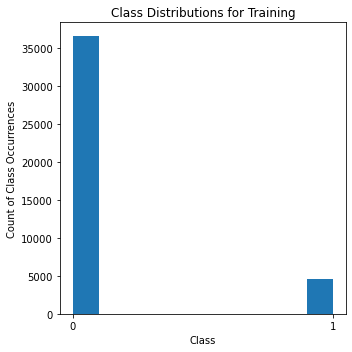

In [14]:
# print distributions
print("Class 0 Distributions for Training:", len(df[df["y"] == 0]))
print("Class 1 Distributions for Training:", len(df[df["y"] == 1]))

# initialize a subplot
fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)

# plot distributions
ax.hist(df["y"])

# add in titles
plt.title("Class Distributions for Training")
plt.ylabel("Count of Class Occurrences")
plt.xlabel("Class")

# modify labels
plt.xticks(df["y"].unique())

plt.show()

In [15]:
df.info()

# create X, y datasets
X = df.copy()
y = df["y"].copy()
X.drop(labels="y", axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  float64
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   campaign        41188 non-null  float64
 8   pdays           41188 non-null  float64
 9   previous        41188 non-null  float64
 10  poutcome        41188 non-null  object 
 11  emp.var.rate    41188 non-null  float64
 12  cons.price.idx  41188 non-null  float64
 13  cons.conf.idx   41188 non-null  float64
 14  euribor3m       41188 non-null  float64
 15  nr.employed     41188 non-null  float64
 16  y               41188 non-null  int64  
 17  job_int         41188 non-null 

In [16]:
# under sample datasets to address class imbalancing
under_sample = RandomUnderSampler(sampling_strategy = 0.7)
X_under, y_under = under_sample.fit_resample(X, y)

Class 0 Distributions for Training: 6628
Class 1 Distributions for Training: 4640


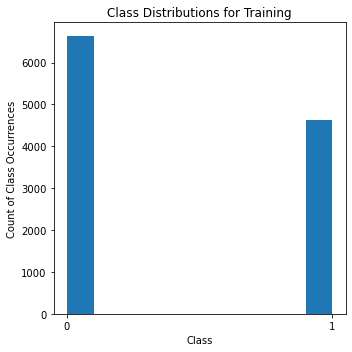

In [17]:
# print distributions
print("Class 0 Distributions for Training:", len(y_under[y_under == 0]))
print("Class 1 Distributions for Training:", len(y_under[y_under == 1]))

# initialize a subplot
fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)

# plot distributions
ax.hist(y_under)

# add in titles
plt.title("Class Distributions for Training")
plt.ylabel("Count of Class Occurrences")
plt.xlabel("Class")

# modify labels
plt.xticks(y_under.unique())

plt.show()

### Cross-Features

>[1 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed).

The first group I will call the personal group.  This group contains features that are personal to a client: job, marriage status and education.  These make sense because these create a rough estimation of who a person is.

The second group of features for crossing will be the financial category.  These features include default, housing, and loan.  These features are appropriate together because this paints the picture of a clients financial health.

The third group of features will be a combination of the above two.  All features will be included: job, marriage status, education, default, housing, and loan.  These features are appropriate because it paints a fuller picture of a client - what life status they have (job, marriage, education) along with current financial picture (default, housing, loan).  Because traditionally all 6 of these categories have been commonly used in banking, I find these appropriate for use in crossing the dataset.

In [18]:
# choose these as a class, what makes sense??
cross_columns = [["job", "marital", "education"],
                 ["default", "housing", "loan"],
                 ["job", "marital", "education", "default", "housing", "loan"]
                ]

### Performance Metrics

>[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

I have implemented a function (similar to the one used in the previous lab) which assesses the Precision, Recall, and F1 scores.  Out of the 3, the most important metric will be precision.  Our aim is to lower our false positives as this model can be used to predict company KPIs.  Company KPIs can be used to predict financial performances.  If KPIs are overpredicted, company financials could be more optimistic than intended.  This could have grave consequences on shareholder expectations. Therefore, from a financial standpoint, **precision is the most important metric**, followed closely by F1.  Both metrics I will assess, but with precision being the more important of the two.

In addition to F1 and Precision, another appropriate metric to monitor is mean binary cross entropy: https://www.tensorflow.org/api_docs/python/tf/keras/metrics

The full list of metrics and losses I will be monitoring:
- Accuracy
- Precision
- BinaryCrossentropy
- AUC
- MeanSquaredError

I have created four helper functions below to plot out the metrics we want to analyze as well as a confusion matrix and a McNemar test for model comparisons.  The average metric function is used to extract the averages of a specified metric from the history of a model

In [19]:
def plot_metrics(scores):
    # plot out loss plus metrics
    plt.figure(figsize=(15,15))
    
    plt.subplot(5,2,1)
    plt.title('Training')
    for score in scores:
        plt.plot(score["binary_crossentropy"])
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend([1,2,3,4,5])
    
    plt.subplot(5,2,3)
    for score in scores:
        plt.plot(score["mean_squared_error"])
    plt.ylabel('MSE Loss')
    
    plt.subplot(5,2,5)
    for score in scores:
        plt.plot(score["precision"])
    plt.ylabel('Precision')
    
    plt.subplot(5,2,7)
    for score in scores:
        plt.plot(score["auc"])
    plt.ylabel('AUC')
    
    plt.subplot(5,2,9)
    for score in scores:
        plt.plot(score["Accuracy"])
    plt.ylabel('Accuracy')
    
    plt.subplot(5,2,2)
    plt.title('Validation')
    for score in scores:
        plt.plot(score["val_binary_crossentropy"])
        
    plt.subplot(5,2,4)
    for score in scores:
        plt.plot(score["val_mean_squared_error"])

    plt.subplot(5,2,6)
    for score in scores:
        plt.plot(score["val_precision"])

    plt.subplot(5,2,8)
    for score in scores:
        plt.plot(score["val_auc"])
        
    plt.subplot(5,2,10)
    for score in scores:
        plt.plot(score["val_Accuracy"])
        
    model_ = 1
    avg_val_precision = []
    for score in scores:
        print(f"Model {model_} Validation Precision:", sum(score["val_precision"])/len(score["val_precision"]))
        avg_val_precision.append(sum(score["val_precision"])/len(score["val_precision"]))
        model_ += 1
        
    print(f"Average Model Validation Precision:", sum(avg_val_precision)/len(avg_val_precision))

In [20]:
def plot_cf_matrix(model, X_test, y_test):
    # predict y using the test dataset
    yhat_proba = model.predict(X_test)
    yhat = np.round(yhat_proba)

    # assess the precision and f1_scores
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))

In [21]:
def mcnemar_test(acc1, acc2):
    t = 2.26 / np.sqrt(10)  # 2.26 is looked up in a book for 95% CI
    e1 = 1-acc1
    e2 = 1-acc1
    e = e1 - e2
    stdtot = np.std(e)
    dbar = np.mean([e1, e2])

    print(dbar - t * stdtot, dbar + t * stdtot)
    return dbar - t * stdtot, dbar + t * stdtot

In [22]:
def avg_metric(scores, metric="precision"):
    # get the average precision for both the first DNN and the best NN
    metric_table = []
    for score in scores:
        if metric_table:
            metric_table = list(np.add(score[metric], metric_table))
        else:
            metric_table += score[metric]    
    metric_table = np.divide(metric_table,5)
    
    return metric_table

### Dataset Splitting

>[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For my dataset split, I have decided on an 80/20 split as there are a fair amount of records, but not enough to justify a 90/10 split and not too few where a 70/30 split is necessary.  If we stratify our output to have a proportional amount between train and test, we can introduce a risk of bias in where our model is expecting that same proportion to be seen with real data.  As evident by the distribution before under sampling, we expect to see an outcome of 1 roughly 10% of the time.  In other words, the campaign was successful in getting a sign for a new product by 10% of the population.

The approach, because our output is binary, is to keep the split and shuffle randomly without stratification.  We will use a Cross Validation approach with a Logistic Regression classifier to see *roughly* what our expected precisions should be.  Anything that is 90%, we should be cautious that our model is simply predicting class 0.  Anything that is about 70% or greater, we can reason that the model is set up in a manner where it can generalize without class imbalance bias.

We will use a split of 5.  Our dataset size is healthy at 10,000 instances, but the more we split, the less data we will have to validate.  I have chosen to include a validation set per model per cross-fold (I will explain my validation threshold later).

As evident below, our splits show about 75% precision - which I am confident that our class balancing has allowed our model to not become biased towards predicting a single class.  Further, a 75% precision indicates that the model is predicting a true positive rate 3 out of every 4 times.  For an economic or financial forecasting model, this is really good.  If I was right 3/4 times for my business decisions, I'd be very wealthy.

Average Precision: 0.7431164164139913


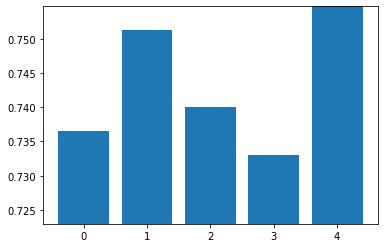

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression

# select a model to roughly estimate cv scores
clf = LogisticRegression()

# select cross validation
cv = ShuffleSplit(n_splits=5)

# select evaluation criteria
my_scorer = make_scorer(precision_score)  # using recall as the scoring criteria

# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X_under[categorical_int_cols + numeric_cols],
                                    y=y_under,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])
print("Average Precision:", np.mean(per_fold_eval_criteria))

In [24]:
# split X, y into Train, Test - we use random state to preserve same split later
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

>[2 points] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

The approach is to create our base models first: A Deep NN and a Wide NN, then combine them into 3 models.  Little analysis will be done for the first two models - I will make some comments, but don't treat these as models to be taken seriously.  The final 3 models in this section will be the models that are worth scrutinizing.

### Defining Model Parameters

I will be using the AdaM optimizer as I believe this is a safe an appropriate optimizer for binary classification.  Our loss function will be MSE (I tetered with switching to Binary Crossentropy but ended up sticking with MSE).  MSE is another safe loss metric to gauge performance and is often used for binary classifications.  Our metrics have been defined above.  Our kernel initializer will be glorot uniform distribution.  I think glorot normal or uniform is the best.  I have no reasoning behind a uniform distribution over a normal distribution other than I have never use the uniform distribution in practice so I thought it would be interesting.  Each layer will have a tanh activation.  Tanh vs Sigmoid is controversial.  Industry best practice states tanh is the better option - I tend to agree.  However, I kept the Sigmoid as the final activation function.  Validation split will be 10%.  If roughly 8,000 records are within our train dataset and we split the dataset 5 times, our validation set will be about 160 instances - which I view as the bare minimum for a validation set.  Additionally, I think a validation set is important in order to gauge model performance per split.

In [25]:
optimizer = "adam"
loss = "mean_squared_error"
metrics = ["Accuracy", "Precision", "BinaryCrossentropy", "AUC", "MeanSquaredError"]
kernel_initializer = "glorot_uniform"
layer_activation = "tanh"
final_activation = "sigmoid"
validation_split = 0.10
epochs = 100
batch_size = 50

### Creating a deep network

In [26]:
# get only the categorical variables
X_train_cat = X_train[categorical_int_cols].to_numpy() 
X_test_cat = X_test[categorical_int_cols].to_numpy()

# get only numerical variables
X_train_num = X_train[numeric_cols].to_numpy()
X_test_num = X_test[numeric_cols].to_numpy()

# this is where we will keep track of output of each branch
all_branch_outputs = []

# create input branch for categircal variables
input_branch_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='input_categorical')

# append embedded layers
for idx,col in enumerate(categorical_int_cols):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_branch_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
# create the input branch and dense branch for numeric side of network
input_branch_num = Input(shape=(X_train_num.shape[1],), dtype='int64', name='input_numeric')
numeric_dense = Dense(units=10, kernel_initializer=kernel_initializer, name="numeric_dense_1")(input_branch_num)

# append numeric dense layers
all_branch_outputs.append(numeric_dense)

# now concatenate the outputs and add a fully connected layer
deep_concat_branch = concatenate(all_branch_outputs, name='deep_concat_branch')
deep_branch1 = Dense(units=16, activation=layer_activation, kernel_initializer=kernel_initializer, name="deep_branch1")(deep_concat_branch)
deep_branch2 = Dense(units=16, activation=layer_activation, kernel_initializer=kernel_initializer, name="deep_branch2")(deep_branch1)
deep_branch3 = Dense(units=8, activation=layer_activation, kernel_initializer=kernel_initializer, name="deep_branch3")(deep_branch2)
deep_final_branch = Dense(units=1, activation=final_activation, name='deep_final')(deep_branch3)

deep_scores = []
# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    X_train_cat_cv = X_train_cat[train_index]
    X_train_num_cv = X_train_num[train_index]
    y_train_cv = y_train.to_numpy()[train_index]
    
    # define model
    deep_model = Model(inputs=[input_branch_cat, input_branch_num], outputs=deep_final_branch)

    # compile model
    deep_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # fit the model
    deep_history = deep_model.fit([X_train_cat_cv, X_train_num_cv], y_train_cv, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=False)
    
    # append scores
    deep_scores.append(deep_history.history)

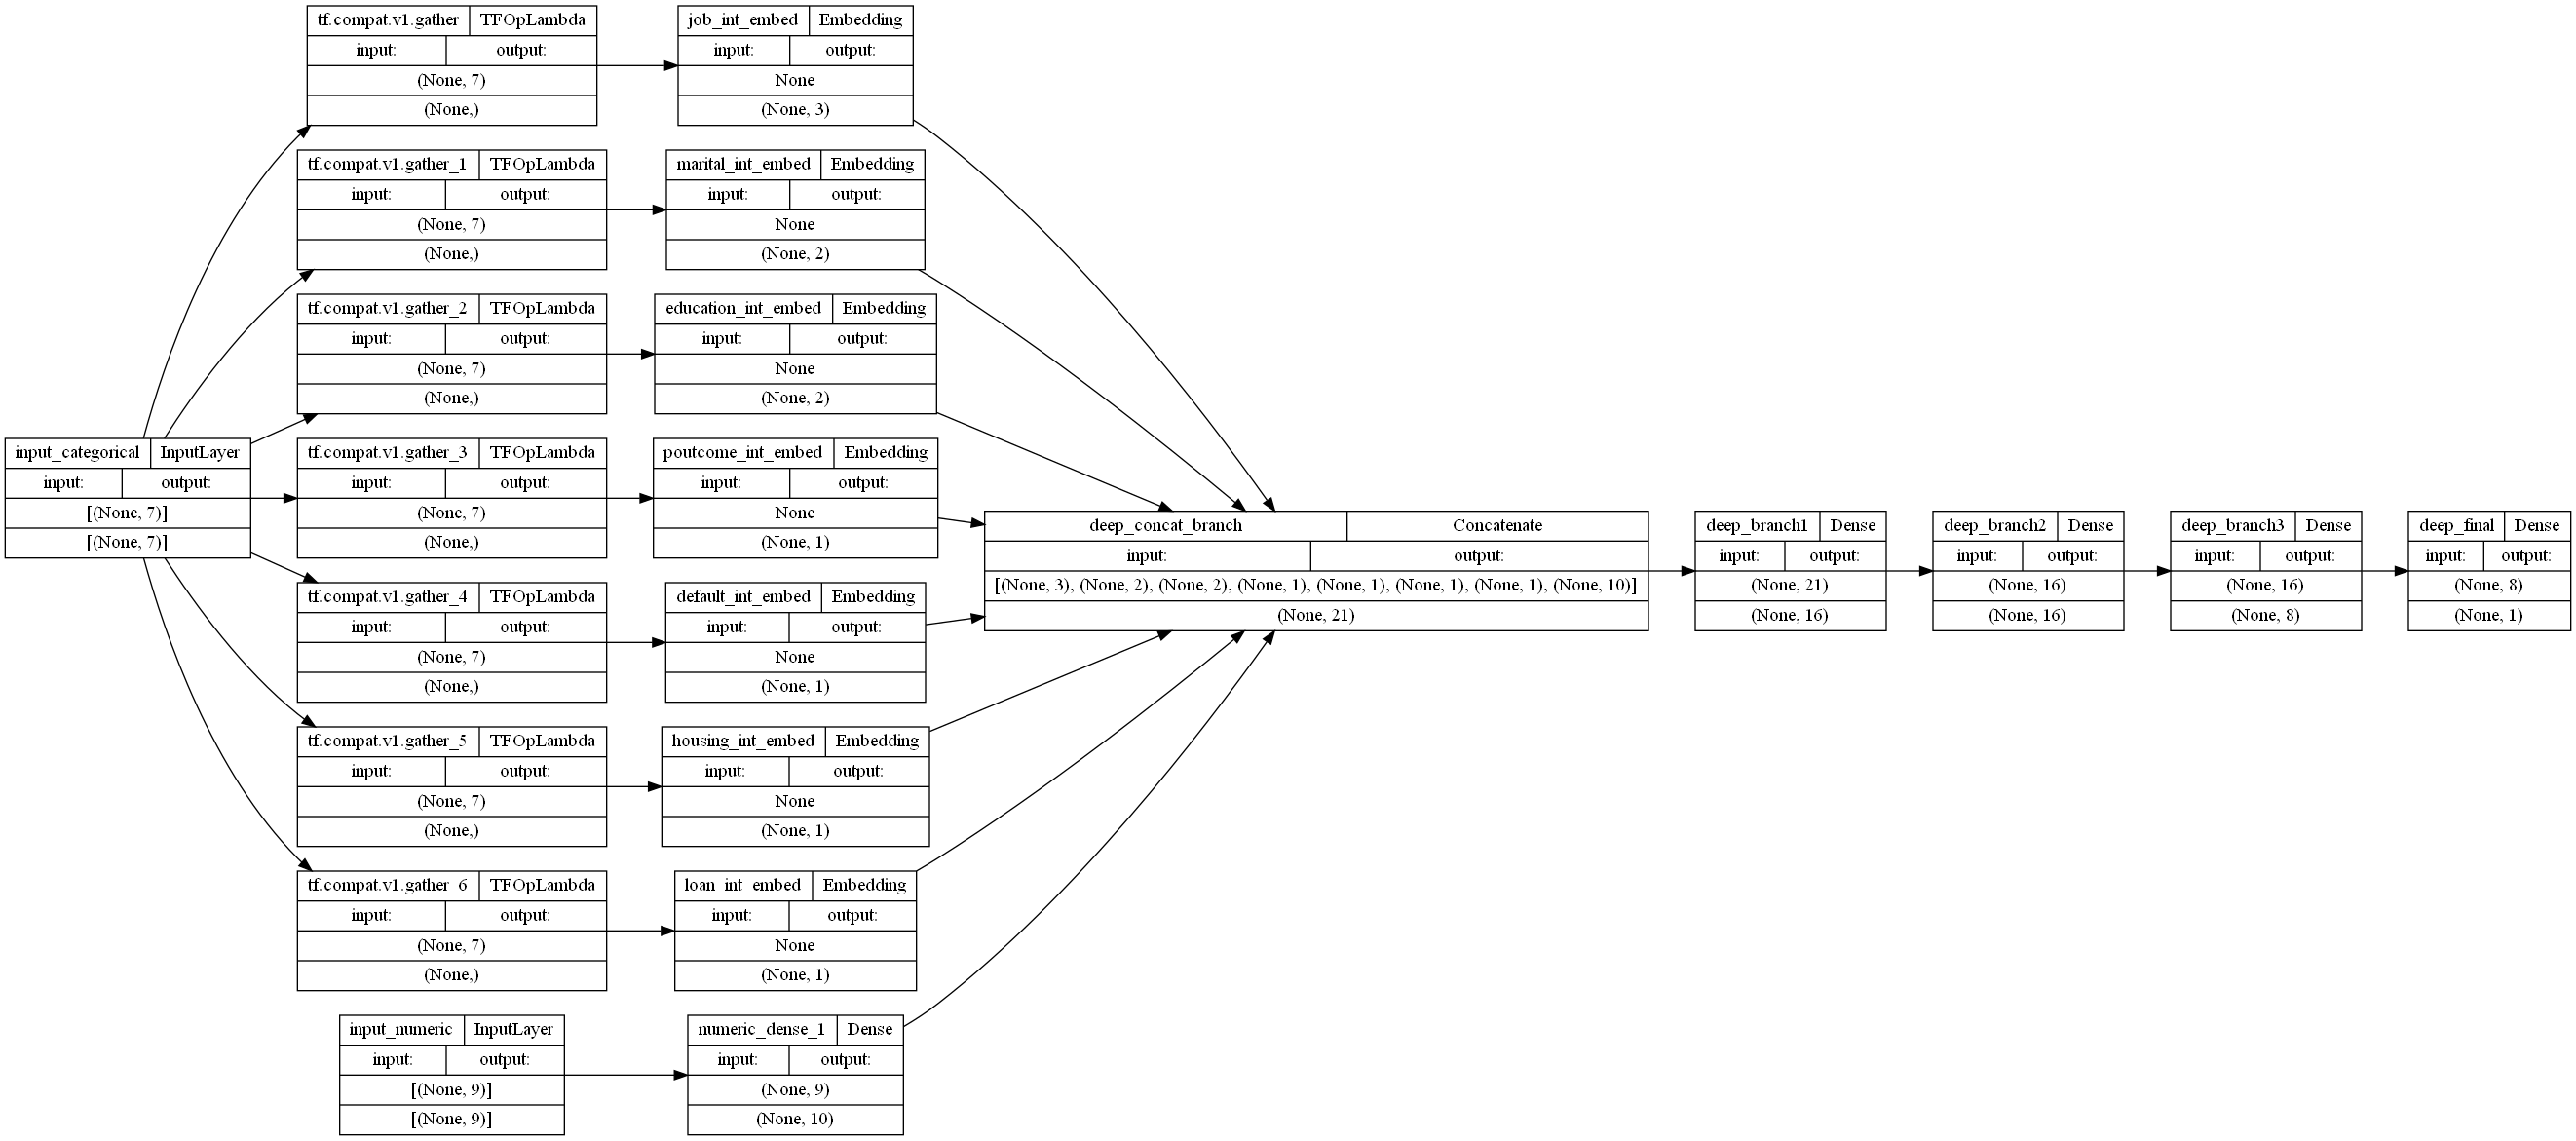

In [27]:
# plot model architecture
plot_model(
    deep_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [28]:
# plot confusion matrix
plot_cf_matrix(deep_model, [X_test_cat, X_test_num], y_test)

[[1100  233]
 [ 399  522]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      1333
           1       0.69      0.57      0.62       921

    accuracy                           0.72      2254
   macro avg       0.71      0.70      0.70      2254
weighted avg       0.72      0.72      0.71      2254



Model 1 Validation Precision: 0.8283656197786331
Model 2 Validation Precision: 0.7725315028429032
Model 3 Validation Precision: 0.8082382774353027
Model 4 Validation Precision: 0.7358305251598358
Model 5 Validation Precision: 0.803986279964447
Average Model Validation Precision: 0.7897904410362244


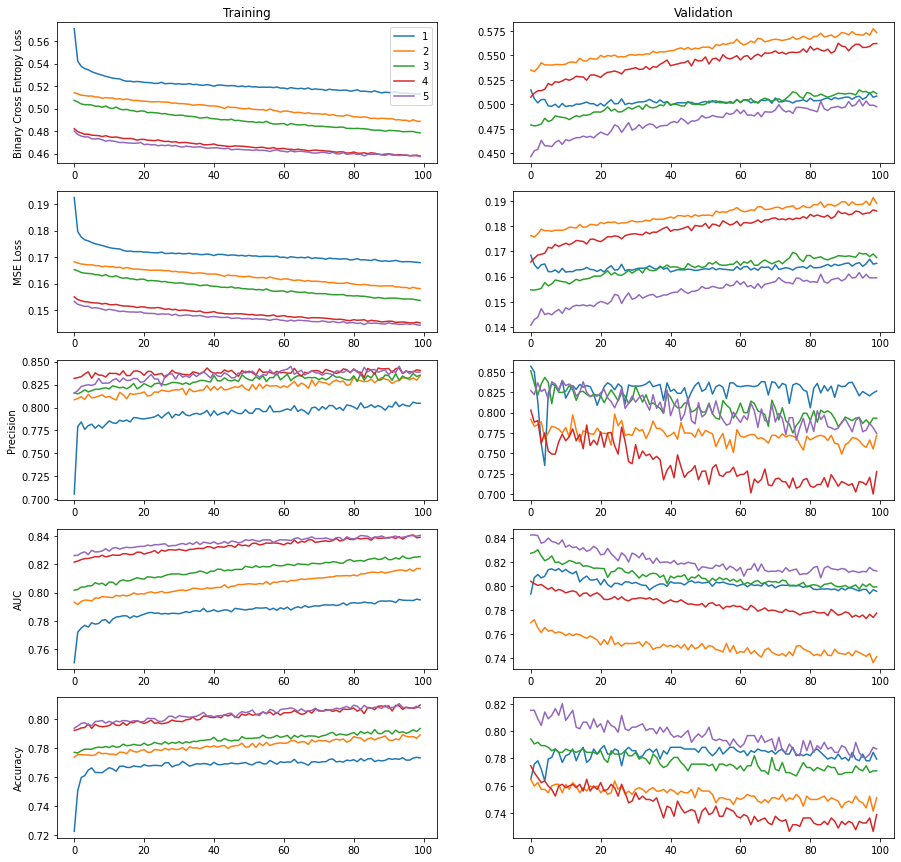

In [29]:
# plot metrics
plot_metrics(deep_scores)

As stated above, I won't go into too deep of an analysis as this is a setup model.  However, it is worth noting that our average validation precision is about 79% which is very good considering we have further enhancements to our model.

### Creating a Wide Network

In [30]:
# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
        
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 

In [31]:
# get only the categorical variables
X_train_cross = X_train[cross_col_df_names].to_numpy() 
X_test_cross = X_test[cross_col_df_names].to_numpy()

crossed_outputs = [] # this is where we will keep track of output of each branch

input_branch_crossed = Input(shape=(X_train_cross.shape[1],), dtype='int64', name='input_crossed')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(X_train[col].max(),X_test[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_branch_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_concat_branch = concatenate(crossed_outputs, name='wide_concat_branch')
wide_final_branch = Dense(units=1,activation=final_activation, name='wide_final')(wide_concat_branch)

wide_scores = []
# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    X_train_cross_cv = X_train_cross[train_index]
    y_train_cv = y_train.to_numpy()[train_index]
    
    # define model
    wide_model = Model(inputs=[input_branch_crossed], outputs=wide_final_branch)

    # compile model
    wide_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # fit the model
    wide_history = wide_model.fit([X_train_cross_cv], y_train_cv, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=False)
    
    # append scores
    wide_scores.append(wide_history.history)

In [32]:
# plot confusion matrix
plot_cf_matrix(wide_model, X_test_cross, y_test)

[[1116  217]
 [ 676  245]]
              precision    recall  f1-score   support

           0       0.62      0.84      0.71      1333
           1       0.53      0.27      0.35       921

    accuracy                           0.60      2254
   macro avg       0.58      0.55      0.53      2254
weighted avg       0.58      0.60      0.57      2254



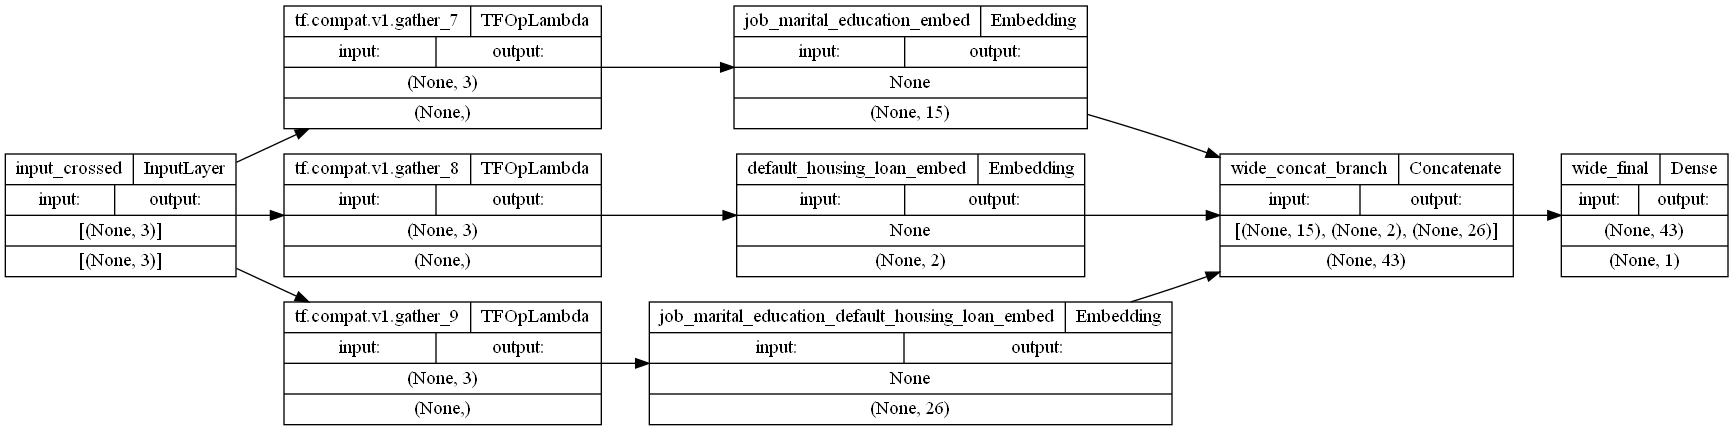

In [33]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    wide_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model 1 Validation Precision: 0.5141012427210808
Model 2 Validation Precision: 0.5674765247106552
Model 3 Validation Precision: 0.5366862642765046
Model 4 Validation Precision: 0.5654548364877701
Model 5 Validation Precision: 0.6157421839237213
Average Model Validation Precision: 0.5598922104239464


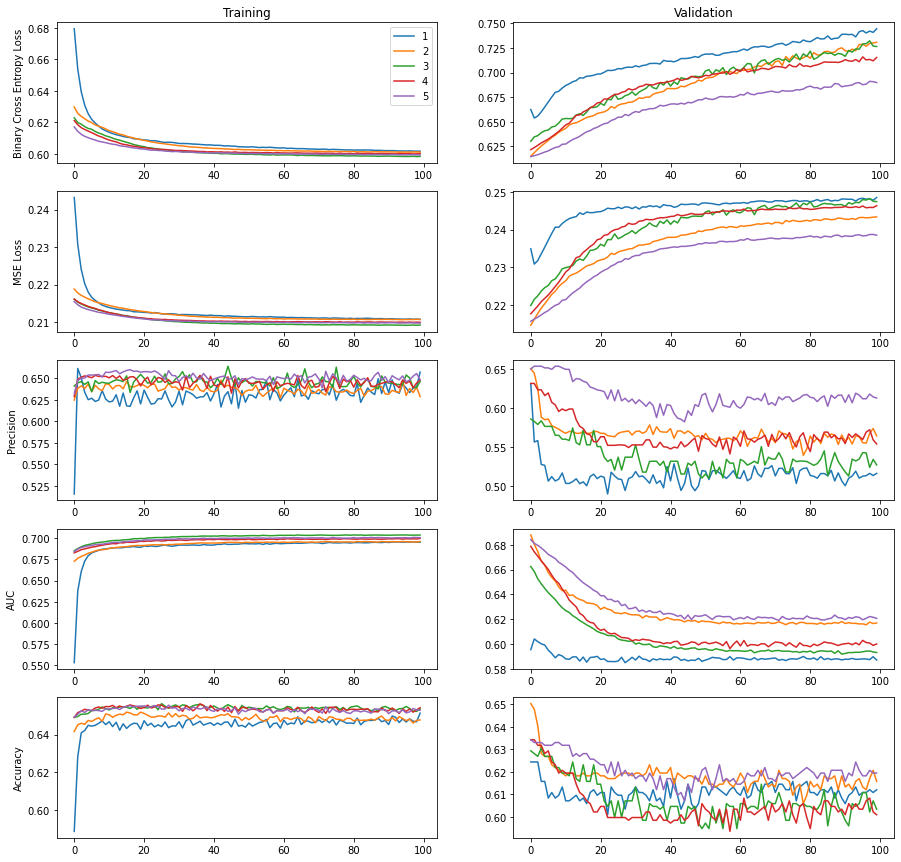

In [34]:
# plot metrics
plot_metrics(wide_scores)

As with our deep network above, these is not much to say about this model because it is used for setup.  It is not surprising that the wide model has poorer precision and other metrics compared to its deep counterpart because the dataset is much narrower and does not provide a lot of sensible categories to combine together.

### Combining Networks

We now combine the deep and wide networks above into a single network.  For this section, we will create 3 different combo networks, each with the same amount of deep layers but altering the number of column combinations used:
1. Will have only default-housing-loan column combination as I think this is a more telling set of features as opposed to job-marital-education
2. Will have only job-marital-education and default-housing-loan column combinations but not the inter combination as network 1 has
3. Will have all 3 column combinations

We only need to create a new concat branch that takes the last deep branch (before final branch) and last wide branch (before final branch).

For the model analysis, I will gather my thoughts after the 3rd Combo model is ran.  The next couple sections will only contain code and no analysis.  See the end of the 3rd Combo Model section for a full analysis

#### Combo Model 1

In [36]:
# combine both the deep branch and the wide branch into one
wide_concat_branch3 = concatenate([crossed_outputs[1]], name='wide_concat_branch3')  # Update wide branch to have just 2nd combination
combo_branch = concatenate([deep_branch3, wide_concat_branch3], axis=1, name="combo1")
combo_final = Dense(units=1,activation=final_activation, name='combined')(combo_branch)

combo_scores = []
# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    X_train_cat_cv = X_train_cat[train_index]
    X_train_num_cv = X_train_num[train_index]
    X_train_cross_cv = X_train_cross[train_index]
    y_train_cv = y_train.to_numpy()[train_index]
    
    # define model
    combo_model = Model(inputs=[input_branch_cat, input_branch_num, input_branch_crossed], outputs=combo_final)

    # compile model
    combo_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # fit the model
    combo_history = combo_model.fit([X_train_cat_cv, X_train_num_cv, X_train_cross_cv], y_train_cv, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=False)
    
    # append scores
    combo_scores.append(combo_history.history)

In [37]:
# plot confusion matrix
plot_cf_matrix(combo_model, [X_test_cat, X_test_num, X_test_cross], y_test)

[[1147  186]
 [ 428  493]]
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1333
           1       0.73      0.54      0.62       921

    accuracy                           0.73      2254
   macro avg       0.73      0.70      0.70      2254
weighted avg       0.73      0.73      0.72      2254



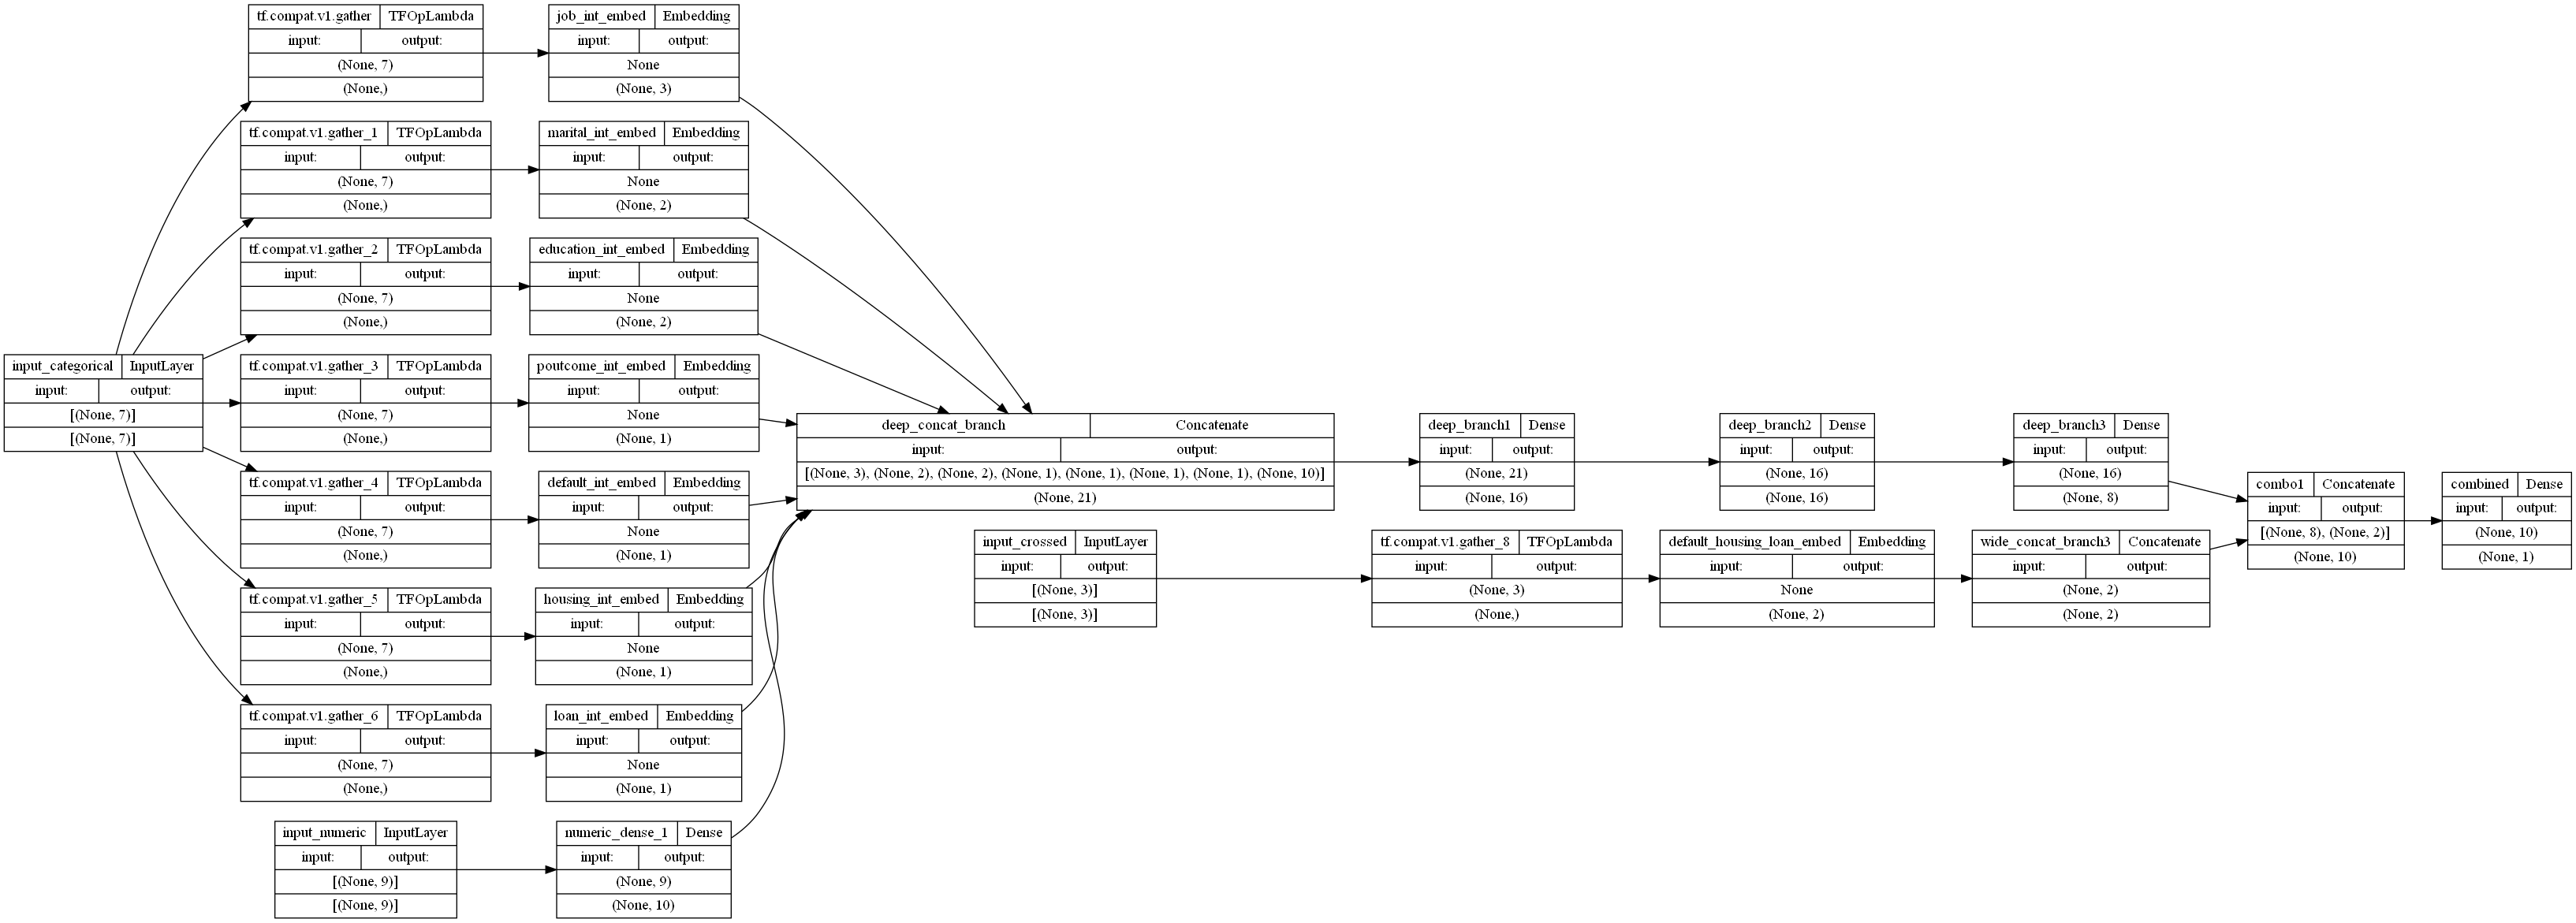

In [38]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    combo_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model 1 Validation Precision: 0.7945703876018524
Model 2 Validation Precision: 0.7894494062662125
Model 3 Validation Precision: 0.7715497899055481
Model 4 Validation Precision: 0.8105378520488739
Model 5 Validation Precision: 0.8241560631990432
Average Model Validation Precision: 0.798052699804306


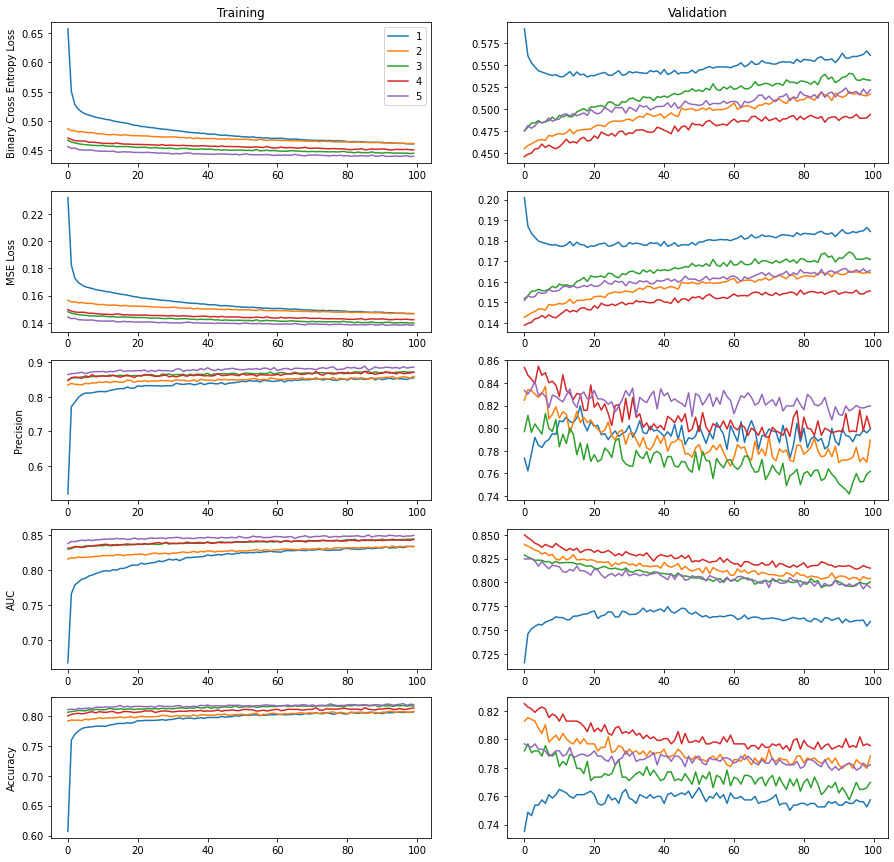

In [39]:
# plot metrics
plot_metrics(combo_scores)

#### Combo Model 2

In [40]:
# combine both the deep branch and the wide branch into one
wide_concat_branch2 = concatenate(crossed_outputs[:2], name='wide_concat_branch2')  # Update wide branch to have just first 2 combinations
combo_branch = concatenate([deep_branch3, wide_concat_branch2], axis=1, name="combo1")
combo_final = Dense(units=1,activation=final_activation, name='combined')(combo_branch)

combo2_scores = []
# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    X_train_cat_cv = X_train_cat[train_index]
    X_train_num_cv = X_train_num[train_index]
    X_train_cross_cv = X_train_cross[train_index]
    y_train_cv = y_train.to_numpy()[train_index]
    
    # define model
    combo2_model = Model(inputs=[input_branch_cat, input_branch_num, input_branch_crossed], outputs=combo_final)

    # compile model
    combo2_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # fit the model
    combo2_history = combo2_model.fit([X_train_cat_cv, X_train_num_cv, X_train_cross_cv], y_train_cv, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=False)
    
    # append scores
    combo2_scores.append(combo2_history.history)

In [41]:
# plot confusion matrix
plot_cf_matrix(combo2_model, [X_test_cat, X_test_num, X_test_cross], y_test)

[[1106  227]
 [ 408  513]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      1333
           1       0.69      0.56      0.62       921

    accuracy                           0.72      2254
   macro avg       0.71      0.69      0.70      2254
weighted avg       0.72      0.72      0.71      2254



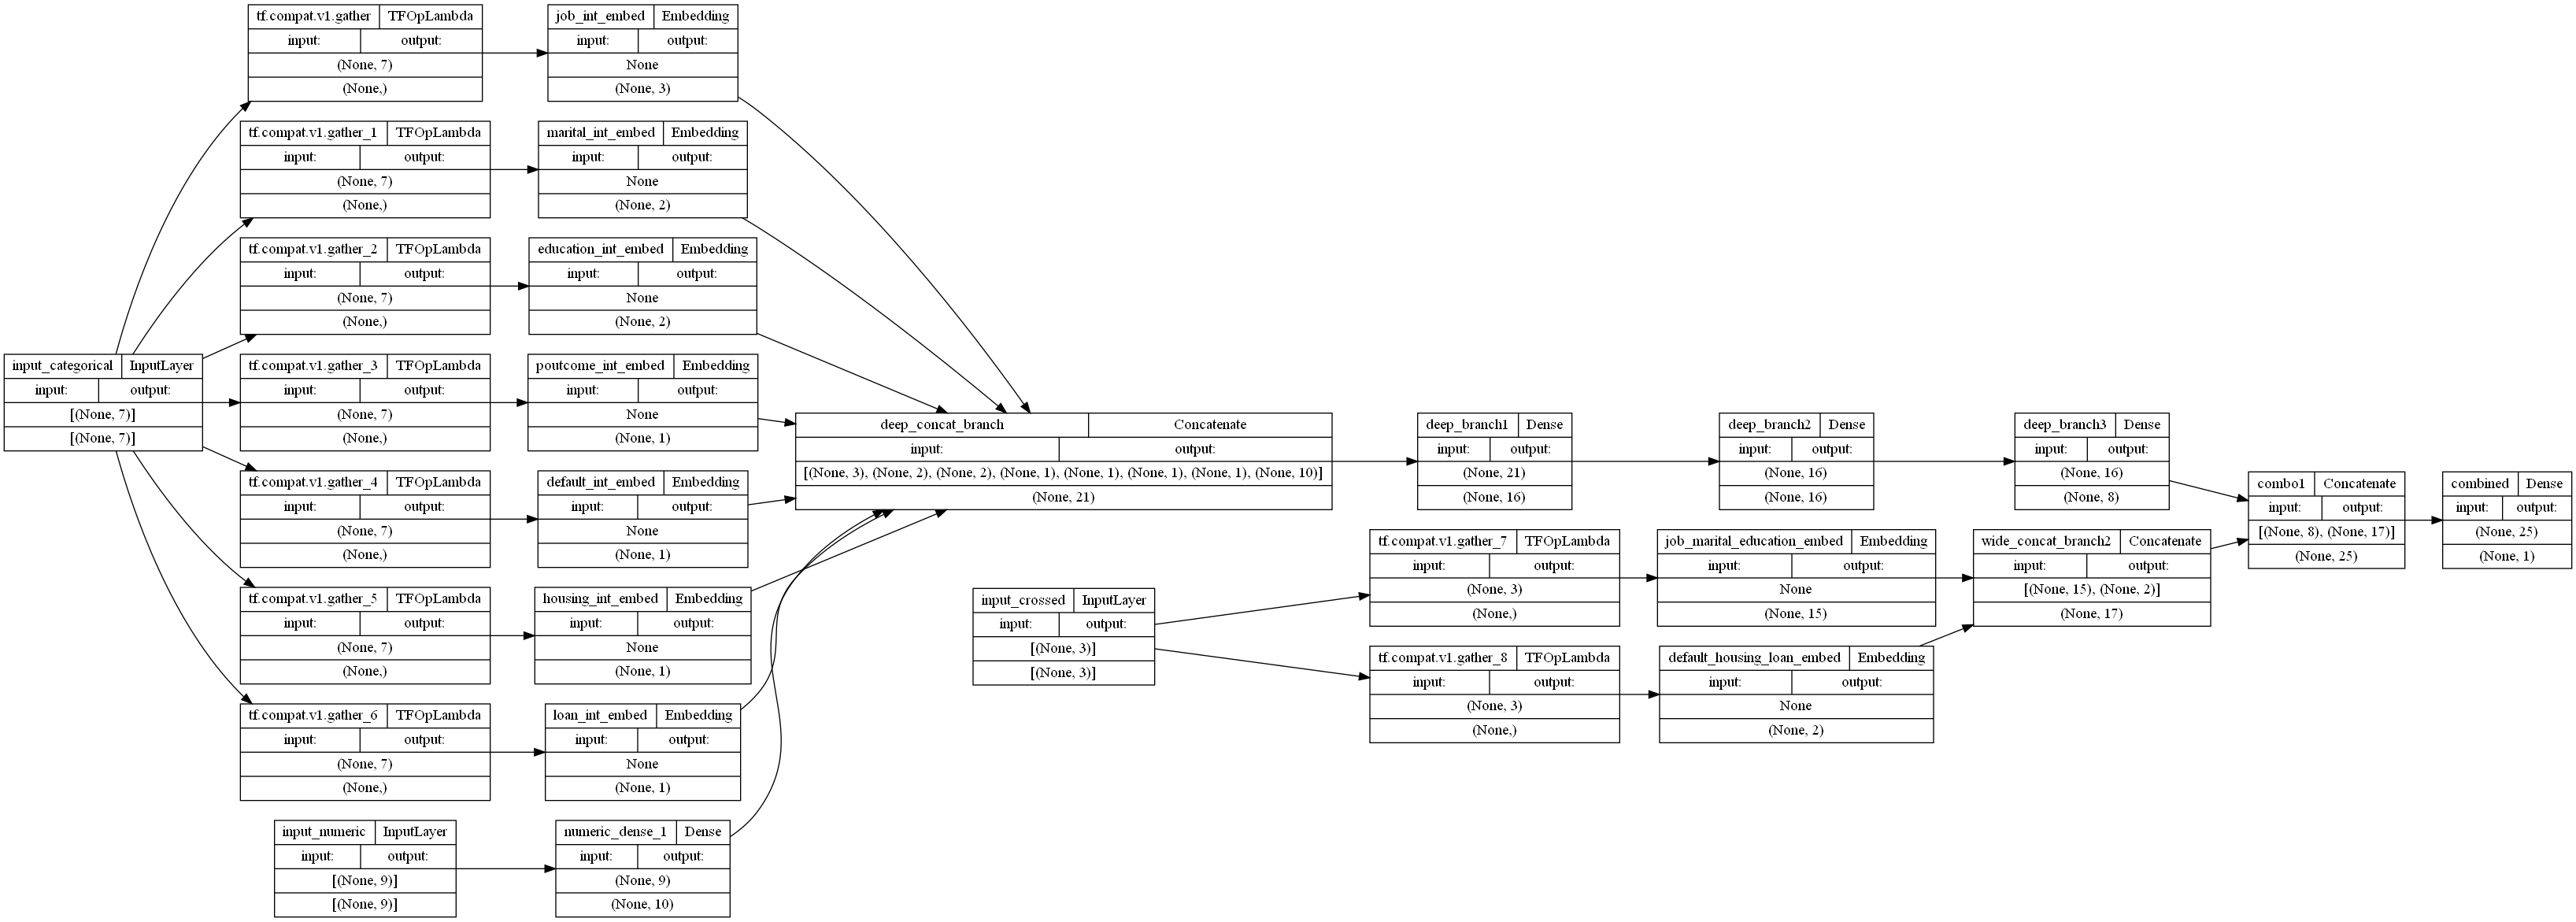

In [42]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    combo2_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model 1 Validation Precision: 0.796891832947731
Model 2 Validation Precision: 0.8419430971145629
Model 3 Validation Precision: 0.8165561473369598
Model 4 Validation Precision: 0.8115758520364761
Model 5 Validation Precision: 0.8031383764743805
Average Model Validation Precision: 0.8140210611820221


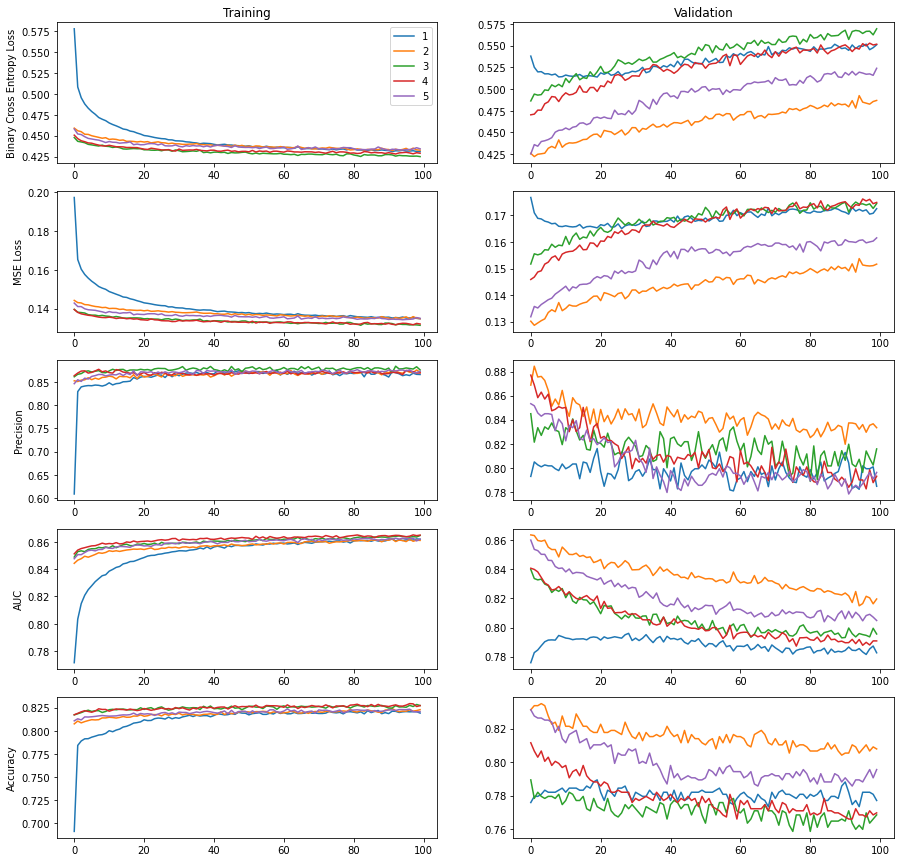

In [43]:
# plot metrics
plot_metrics(combo2_scores)

#### Combo Model 3

In [44]:
# combine both the deep branch and the wide branch into one
combo_branch = concatenate([deep_branch3, wide_concat_branch], axis=1, name="combo1")
combo_final = Dense(units=1,activation=final_activation, name='combined')(combo_branch)

combo3_scores = []
# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    X_train_cat_cv = X_train_cat[train_index]
    X_train_num_cv = X_train_num[train_index]
    X_train_cross_cv = X_train_cross[train_index]
    y_train_cv = y_train.to_numpy()[train_index]
    
    # define model
    combo3_model = Model(inputs=[input_branch_cat, input_branch_num, input_branch_crossed], outputs=combo_final)

    # compile model
    combo3_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # fit the model
    combo3_history = combo3_model.fit([X_train_cat_cv, X_train_num_cv, X_train_cross_cv], y_train_cv, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=False)
    
    # append scores
    combo3_scores.append(combo3_history.history)

In [45]:
# plot confusion matrix
plot_cf_matrix(combo3_model, [X_test_cat, X_test_num, X_test_cross], y_test)

[[1066  267]
 [ 404  517]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1333
           1       0.66      0.56      0.61       921

    accuracy                           0.70      2254
   macro avg       0.69      0.68      0.68      2254
weighted avg       0.70      0.70      0.70      2254



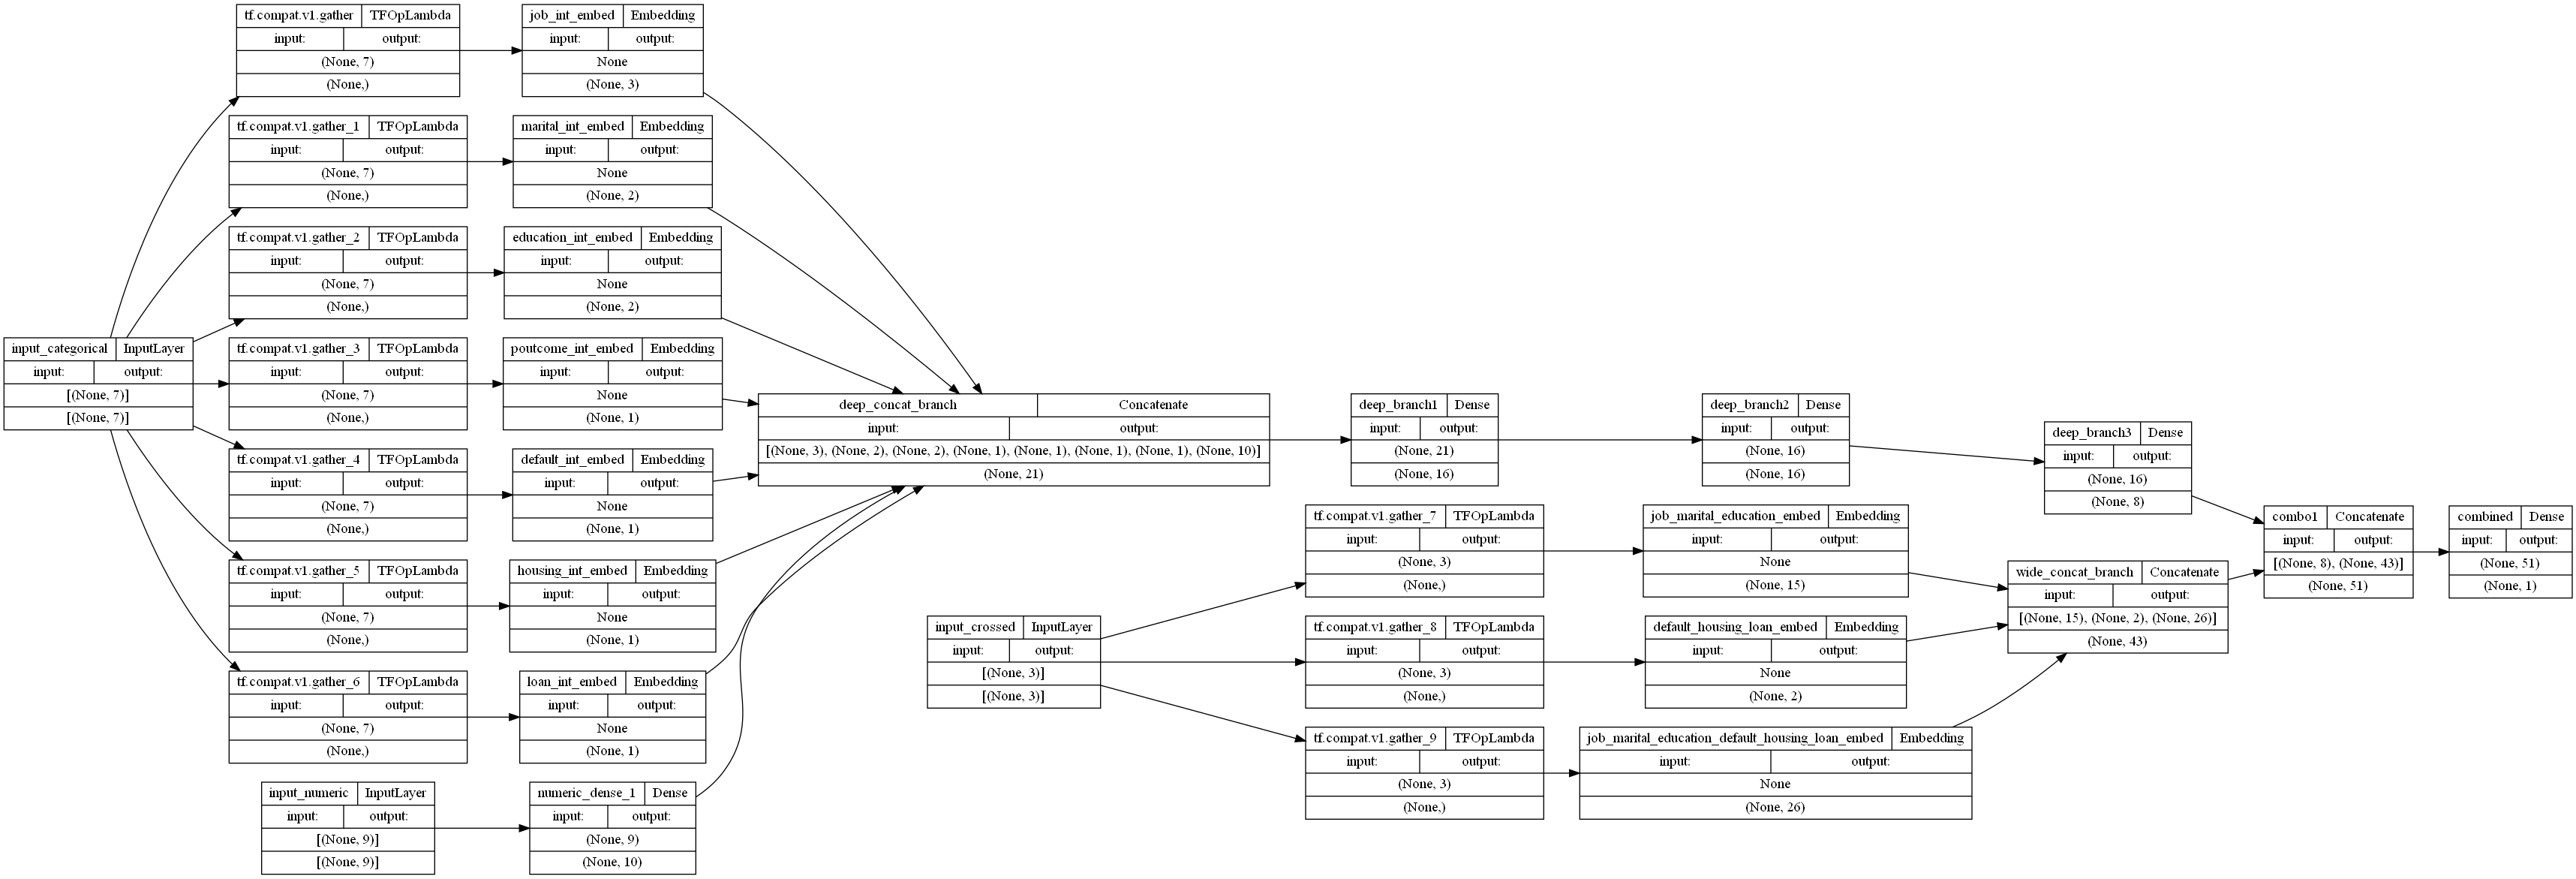

In [46]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    combo3_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model 1 Validation Precision: 0.7624661433696747
Model 2 Validation Precision: 0.8253872954845428
Model 3 Validation Precision: 0.7826786696910858
Model 4 Validation Precision: 0.7917768096923828
Model 5 Validation Precision: 0.7837516182661056
Average Model Validation Precision: 0.7892121073007583


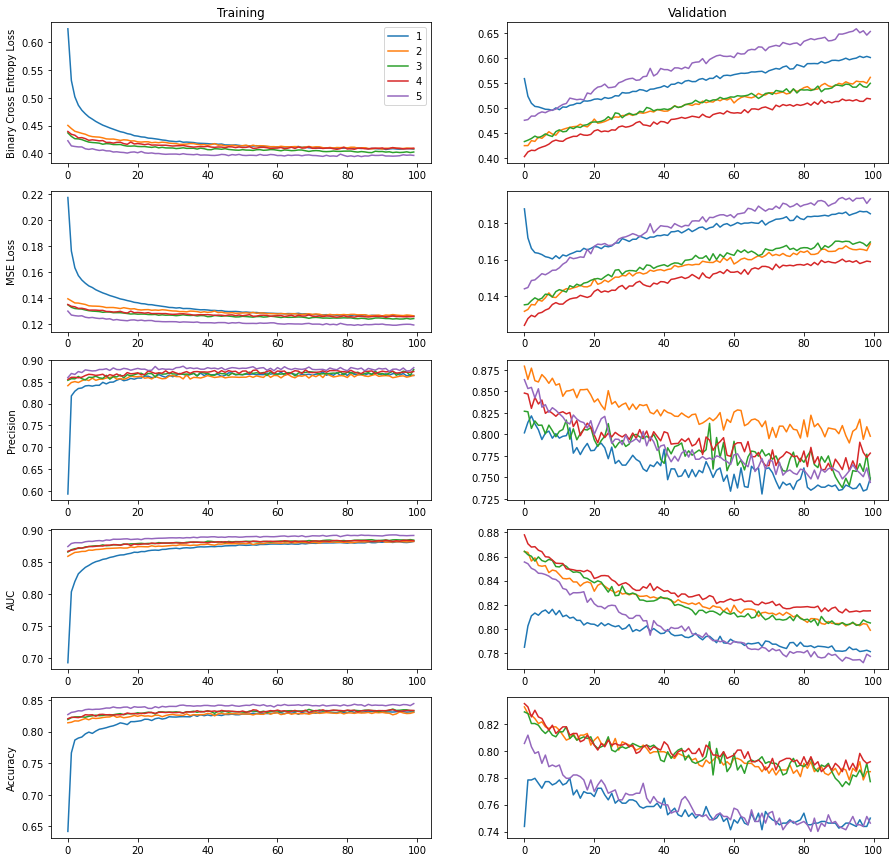

In [47]:
# plot metrics
plot_metrics(combo3_scores)

In [48]:
# perform McNemar testing
combo_accuracy = avg_metric(combo_scores, metric="val_Accuracy")
combo2_accuracy = avg_metric(combo2_scores, metric="val_Accuracy")
combo3_accuracy = avg_metric(combo3_scores, metric="val_Accuracy")

mcnemar_test(combo_accuracy, combo2_accuracy)
mcnemar_test(combo_accuracy, combo3_accuracy)
mcnemar_test(combo2_accuracy, combo3_accuracy)

0.21784236836433407 0.21784236836433407
0.21784236836433407 0.21784236836433407
0.21083990228176117 0.21083990228176117


(0.21083990228176117, 0.21083990228176117)

This is interesting.  We would have expected the combination neural network with all 3 types of combinations as specified at the beginning of this notebook to be the superior model.  But, per the analysis above, it's clear the combo model 2 is the better model based on our foundational metric, precision.  Additionally, our confusion matrix supports our claim.  Looking at the Precision column of our confusion matrix, we have healthy precisions as Class 0 with 73% and Class 1 at 70%.  Only our first combination model out performed these metrics, but had a lower overall average precision.

Another concern is the increase in loss and the decrease in our performance metrics for our validation data.  Could this be due to the number of neurons per layer?  In any case, this is concerning as it appears all metrics are being overfitted.  But I would argue it's not necessarily the case of overfitting because each validation metric is within 1-2% of the average of the train model metrics.  Our best model moving forward will be combo model 2

Looking at our McNemar tests, we see that all 3 tests do not pass over 0.  Therefore, with a 95% confidence, we can deduce that all models differ from eachother and we can not reject the null hypothesis.

### Adding Deep Layers

>[2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly

For this section, I have created 2 more models in which I add a single layer to the already existing combo model from above.  I use only two combinations for this exercise.  As in, you will see that the 2nd widest neural network in addition to a deep network of 4 layers will be the first model of this section.  This 2nd widest neural net plus a deep net of 5 layers will be the second part of this section.  I chose to use the 2nd widest net because it performed the best with a precision score of 81%.  Similar to the above section, I will perform the final analysis after the Combo Model with Deep 5.

#### Combo Model with Deep 4

In [50]:
# create another deep layer
deep_branch4 = Dense(units=8, kernel_initializer=kernel_initializer, name="deep_branch4")(deep_branch3)

# combine new deep branch with 3 combination wide branch
combo_branch = concatenate([deep_branch4, wide_concat_branch2], axis=1, name="combo1")
combo_final = Dense(units=1,activation=final_activation, name='combined')(combo_branch)

deep4_scores = []
# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    X_train_cat_cv = X_train_cat[train_index]
    X_train_num_cv = X_train_num[train_index]
    X_train_cross_cv = X_train_cross[train_index]
    y_train_cv = y_train.to_numpy()[train_index]
    
    # define model
    deep4_model = Model(inputs=[input_branch_cat, input_branch_num, input_branch_crossed], outputs=combo_final)

    # compile model
    deep4_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # fit the model
    deep4_history = deep4_model.fit([X_train_cat_cv, X_train_num_cv, X_train_cross_cv], y_train_cv, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=False)
    
    # append scores
    deep4_scores.append(deep4_history.history)

In [51]:
# plot confusion matrix
plot_cf_matrix(deep4_model, [X_test_cat, X_test_num, X_test_cross], y_test)

[[1116  217]
 [ 413  508]]
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1333
           1       0.70      0.55      0.62       921

    accuracy                           0.72      2254
   macro avg       0.72      0.69      0.70      2254
weighted avg       0.72      0.72      0.71      2254



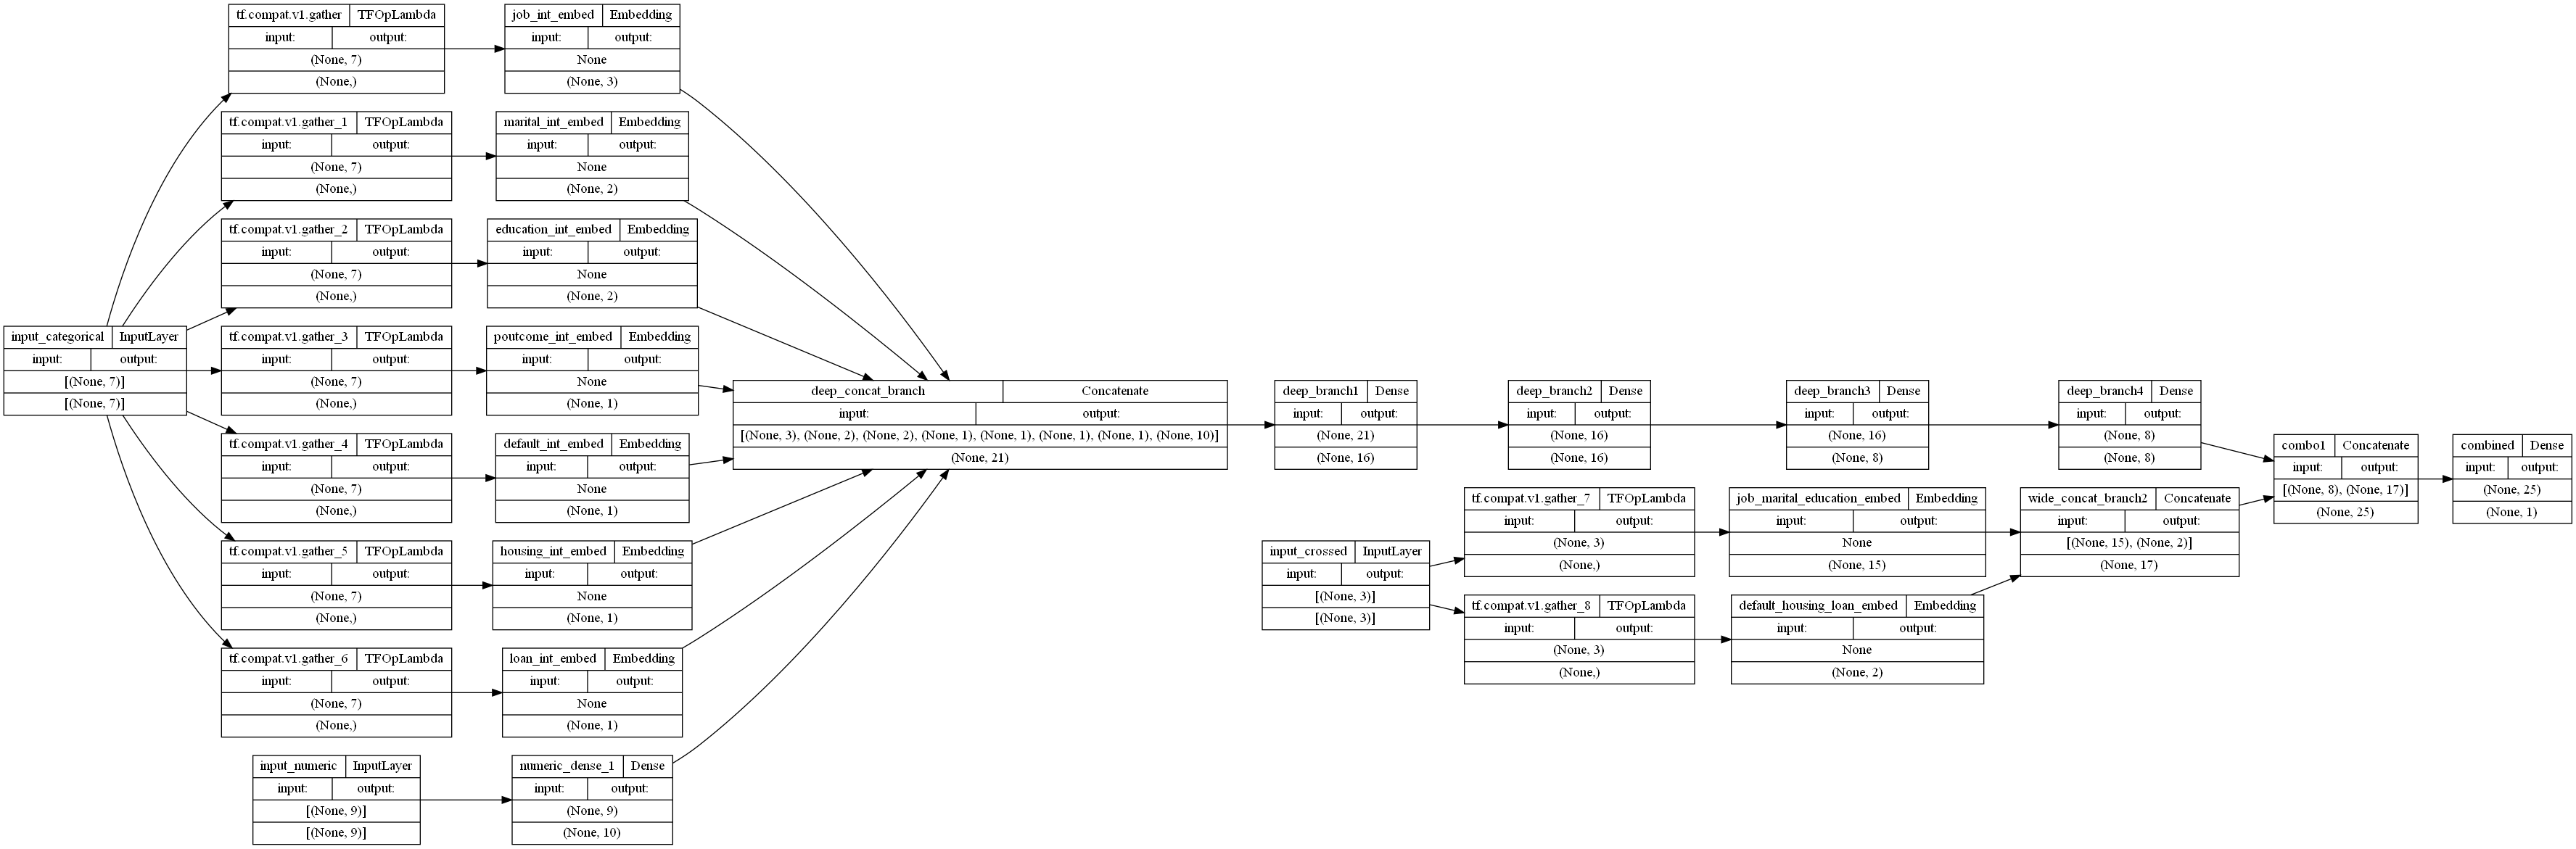

In [52]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    deep4_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model 1 Validation Precision: 0.8178337061405182
Model 2 Validation Precision: 0.7488635736703873
Model 3 Validation Precision: 0.8168457394838333
Model 4 Validation Precision: 0.8002237105369567
Model 5 Validation Precision: 0.772318245768547
Average Model Validation Precision: 0.7912169951200485


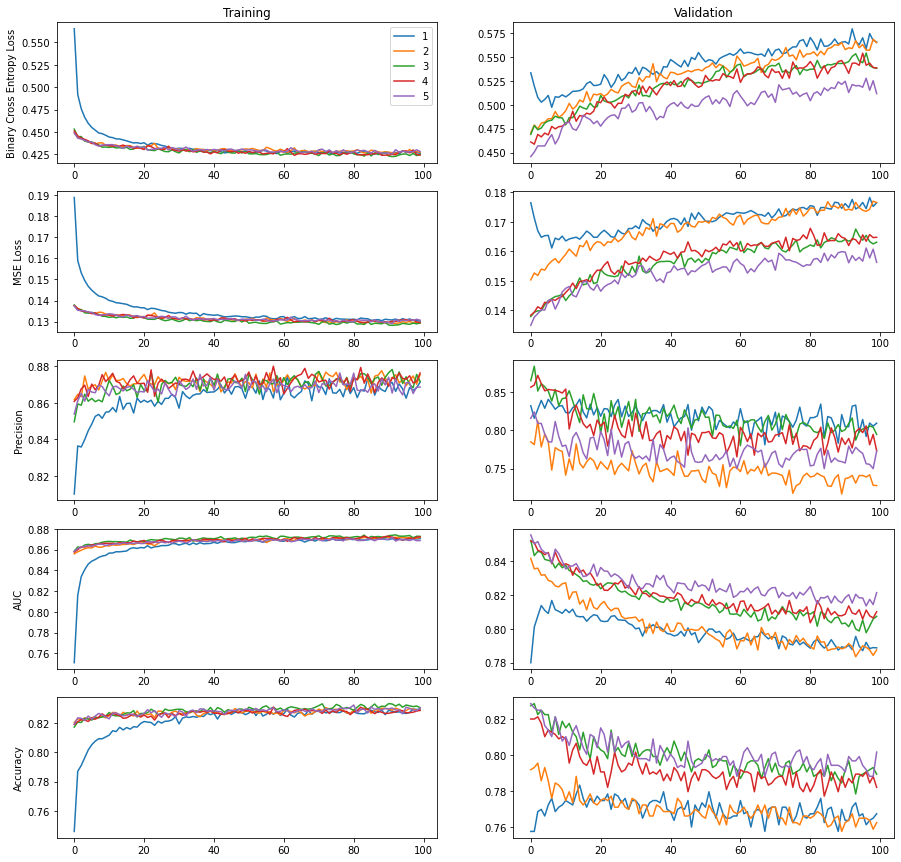

In [53]:
# plot metrics
plot_metrics(deep4_scores)

#### Combo Model with Deep 5

In [54]:
# create another deep layer
deep_branch5 = Dense(units=4, kernel_initializer=kernel_initializer, name="deep_branch5")(deep_branch4)

# combine new deep branch with 3 combination wide branch
combo_branch = concatenate([deep_branch5, wide_concat_branch2], axis=1, name="combo1")
combo_final = Dense(units=1, activation=final_activation, name='combined')(combo_branch)

deep5_scores = []
# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    X_train_cat_cv = X_train_cat[train_index]
    X_train_num_cv = X_train_num[train_index]
    X_train_cross_cv = X_train_cross[train_index]
    y_train_cv = y_train.to_numpy()[train_index]
    
    # define model
    deep5_model = Model(inputs=[input_branch_cat, input_branch_num, input_branch_crossed], outputs=combo_final)

    # compile model
    deep5_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # fit the model
    deep5_history = deep5_model.fit([X_train_cat_cv, X_train_num_cv, X_train_cross_cv], y_train_cv, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=False)
    
    # append scores
    deep5_scores.append(deep5_history.history)

In [55]:
# plot confusion matrix
plot_cf_matrix(deep5_model, [X_test_cat, X_test_num, X_test_cross], y_test)

[[1083  250]
 [ 411  510]]
              precision    recall  f1-score   support

           0       0.72      0.81      0.77      1333
           1       0.67      0.55      0.61       921

    accuracy                           0.71      2254
   macro avg       0.70      0.68      0.69      2254
weighted avg       0.70      0.71      0.70      2254



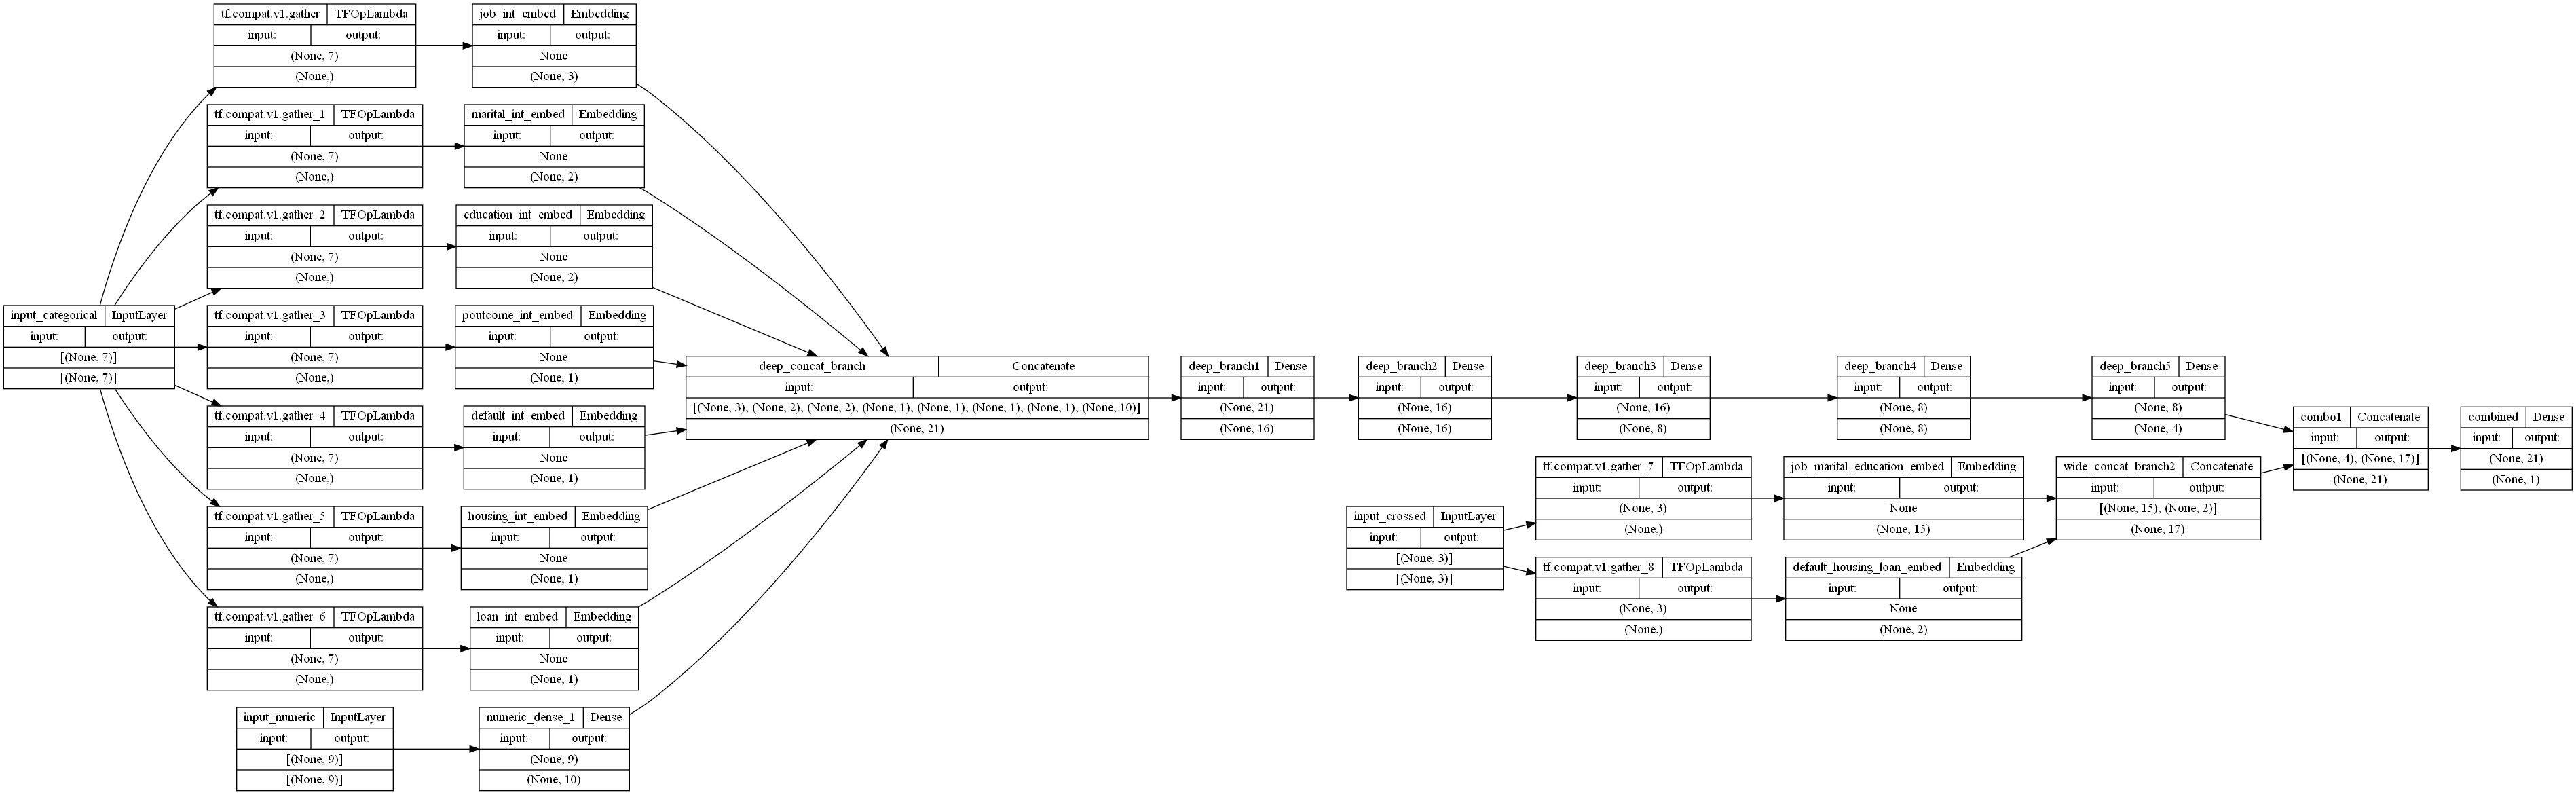

In [56]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    deep5_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Model 1 Validation Precision: 0.8300047427415848
Model 2 Validation Precision: 0.8366537594795227
Model 3 Validation Precision: 0.8545660489797592
Model 4 Validation Precision: 0.7919795751571655
Model 5 Validation Precision: 0.7785537481307984
Average Model Validation Precision: 0.818351574897766


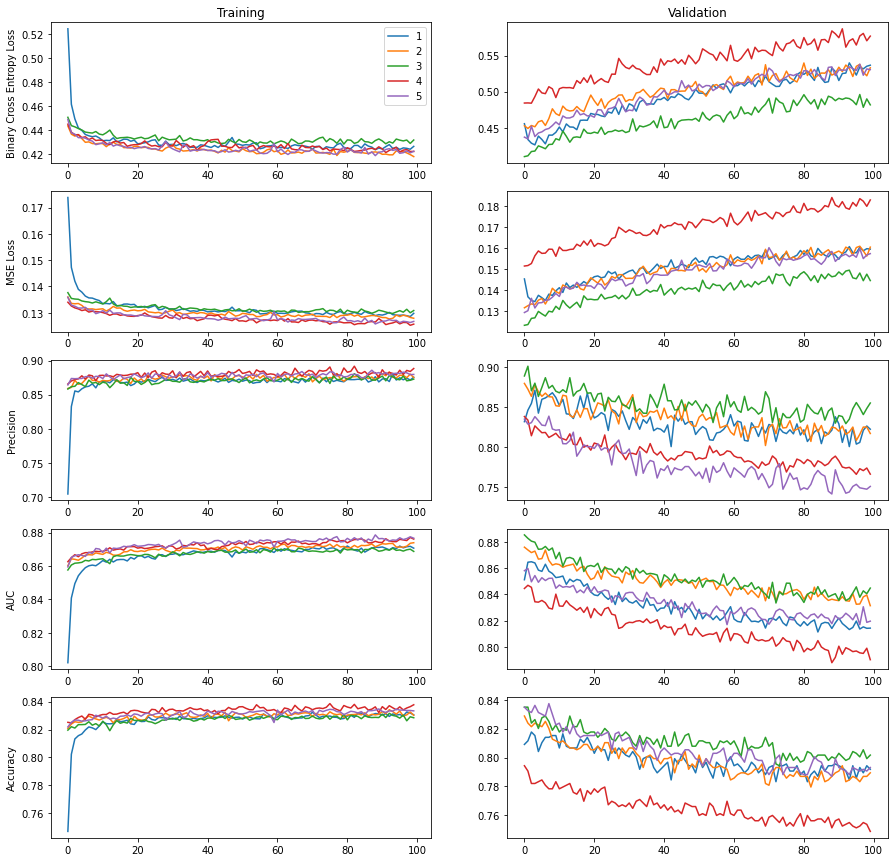

In [57]:
# plot metrics
plot_metrics(deep5_scores)

It appears that the deep 5 model is the best performing model based on precision, with a score of 82%.  Although, it is interesting how the deep 4 model did not perform better than our best combo model, but deep 5 did.  When looking at the training metrics, each metric makes sense.  The curves make sense.  But, when looking at validation, I can't help but think that maybe overfitting is still occurring.  The magnitude at which we decrease for each epoch warrants an analysis into why we may be overfitting.  It may be because I chose not to stratify the output variable "y", and because both the class 0 and class 1 were purposefully under sampled for the entire dataset at a specific proportional rate, I should have also stratified y.  Thereby having the same proportions between both the train and test sets, as opposed to the current state where it is random.  I will stand by this analysis however, even if it is wrong.

### Best Model vs Deep Neural Network

>[1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.

For this section, I will be comparing my best model with the first deep model created above in the first section.  There will be 3 metrics used to assess performance:
- Precision
- Area Under the Curve
- McNemar Test

I believe each 3 have something to offer for analyses and are appropriate when identifying which model is the more superior performer.  Full Analysis will be held at the end of this section

In [58]:
deep_precision = avg_metric(scores=deep_scores, metric="val_precision")
deep5_precision = avg_metric(scores=deep5_scores, metric="val_precision")

In [59]:
# get the average AUC for both the first DNN and the best NN 
deep_auc = avg_metric(scores=deep_scores, metric="val_auc")
deep5_auc = avg_metric(scores=deep5_scores, metric="val_auc")

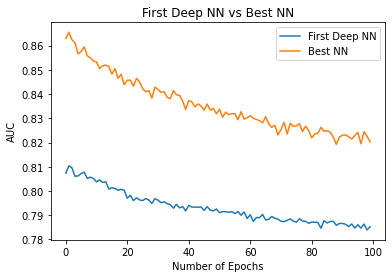

In [60]:
# plot out First Deep NN vs Best NN
plt.title('First Deep NN vs Best NN')
plt.plot(deep_auc)
plt.plot(deep5_auc)
plt.ylabel('AUC')
plt.xlabel('Number of Epochs')
plt.legend(["First Deep NN", "Best NN"])

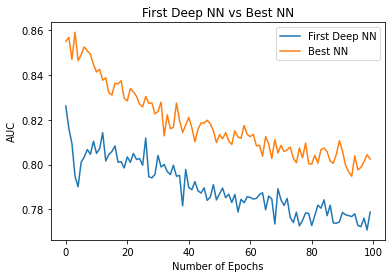

In [61]:
# plot out First Deep NN vs Best NN
plt.title('First Deep NN vs Best NN')
plt.plot(deep_precision)
plt.plot(deep5_precision)
plt.ylabel('AUC')
plt.xlabel('Number of Epochs')
plt.legend(["First Deep NN", "Best NN"])

In [63]:
# mcnemar test between models
deep_accuracy = avg_metric(scores=deep_scores, metric="val_Accuracy")
deep5_accuracy = avg_metric(scores=deep5_scores, metric="val_Accuracy")

mcnemar_test(deep_accuracy, deep5_accuracy)

0.22879802978038785 0.22879802978038785


(0.22879802978038785, 0.22879802978038785)

Based on the metrics chosen, I can state with confidence that our best neural network is 1. better performing by a relatively wide margin and 2. statistically different than the first deep neural network created at the beginning of this notebook.  But, the concerning factor still looms: we are decreasing in performance per metric, indicating an overfit.

### Exceptional Work: UMAP Dimensionality Reduction

>One idea (required for 7000 level students): Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

In this section, the idea is to extract each embedding layer name.  Extract the weights associated with each embedded name, and then fit a UMAP transformer on top of these weights.  Finally, we assess the magnitude of each of these weights and determine, with certainty, which embedded layer had the most sway and influence on the model.  Full analysis will be held at the end of this section.

#### Embedding Names and Weights

In [88]:
# initialize a umap instance
embedded_umap = umap.UMAP()

# initialize empty list of weights
embed_weights = []

# initialize empty list of embedding names
embeddings = []

# for each embedded layer
for embedded_layer in deep5_model.layers:
    if embedded_layer.name[:-6] in categorical_int_cols[:3] + cross_col_df_names:
        
        # append the embedding names from the model
        print(embedded_layer.name)
        embeddings.append(embedded_layer.name)
        
        # extract weights
        embed_weights.append(np.array(embedded_layer.get_weights()))

# extract vectors
weights = [w[0] for w in embed_weights]

# initialize reductions
reductions = []

# for each weight vector, reduce using UMAP
for w in weights:
    embedding = pd.DataFrame(embedded_umap.fit_transform(w), columns=['UMAP1','UMAP2'])
    reductions.append(embedding)

job_int_embed
marital_int_embed
education_int_embed
job_marital_education_embed
default_housing_loan_embed


#### Reduction plotting

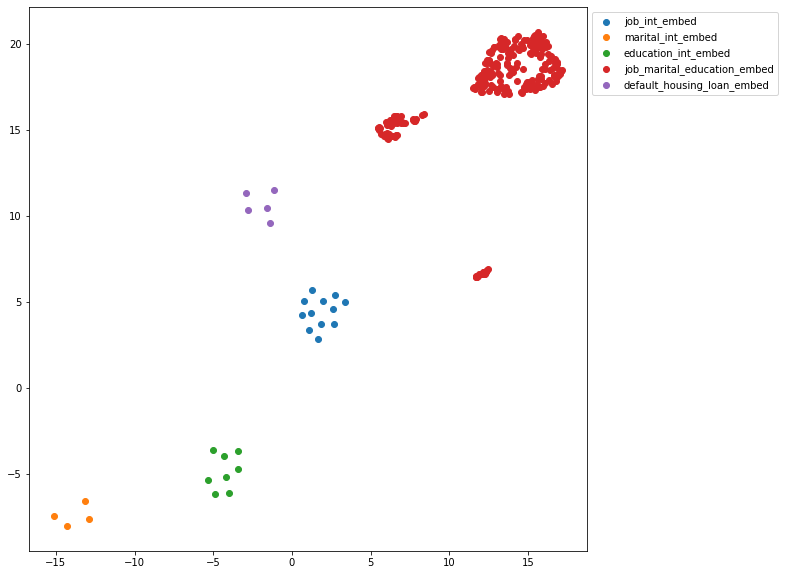

In [89]:
# plot each reductions
plt.figure(figsize = (10, 10))
plt.scatter(x=reductions[0]["UMAP1"], y=reductions[0]["UMAP2"], label="job_int_embed")
plt.scatter(x=reductions[1]["UMAP1"], y=reductions[1]["UMAP2"], label="marital_int_embed")
plt.scatter(x=reductions[2]["UMAP1"], y=reductions[2]["UMAP2"], label="education_int_embed")
plt.scatter(x=reductions[3]["UMAP1"], y=reductions[3]["UMAP2"], label="job_marital_education_embed")
plt.scatter(x=reductions[4]["UMAP1"], y=reductions[4]["UMAP2"], label="default_housing_loan_embed")
# plt.scatter(x=reductions[5]["UMAP1"], y=reductions[5]["UMAP2"], label="job_marital_education_default_housing_loan_embed")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

When plotting the UMAP reduction representations per category, we can see distinct clusters.  Each cluster does not overlap with each other and this type of reduction can be used to deduce the categories which drive the highest variance within the model.  It is safe to say that each of these features are prominent in determing an outcome, but to what magnitude?

#### Embedded Layer Magnitudes

[1.818785309791565, 13.860554695129395, 4.337480545043945, 12.7227783203125, 1.971649408340454]


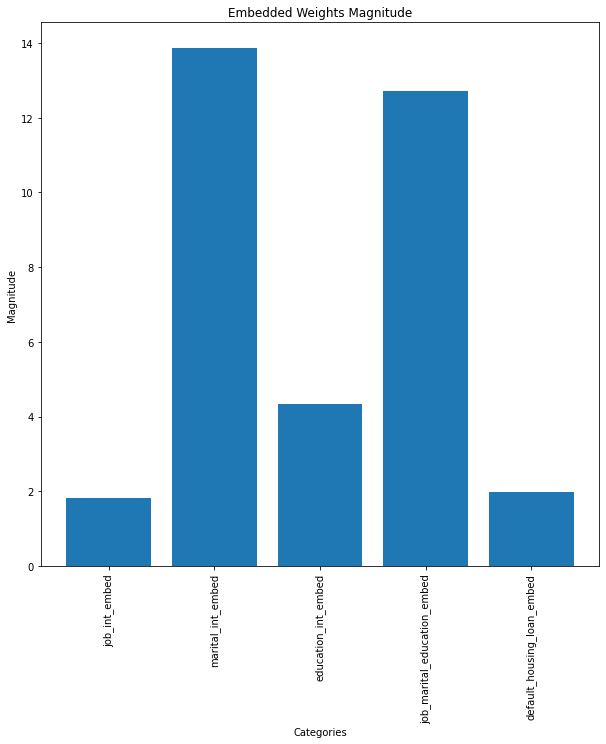

In [106]:
# calculate average reductions
avg_reduction = [np.mean(r["UMAP1"]) for r in reductions]

# initialize subplot
plt.figure(figsize=(10,10))

# set labels
plt.title('Embedded Weights Magnitude')
plt.xticks(ticks=range(len(reductions)), labels=embeddings, rotation=90)
plt.xlabel("Categories")
plt.ylabel("Magnitude")
print(avg_w)
plt.bar(range(len(reductions)), avg_w)
plt.show()

Interesting.  We can see that the most impactful embedding layers are the marital embedded layer and the job-marital-education layer - although looking at the magnitude, it can be argued that all 5 categories are very impactful.  In summary, we can deduce that these 2 most impactful embedding layers have the largest influence when predicting whether a client closes on a new product or not.  Thus, we can allow the sales teams to target these specific categories when new products launch as we can be confident these categories give us greater predictive value.

## Final Thoughts

Our most influential categorical values were marital status and job-marital-education status.  Additionally, we have achieved around an 82% precision (with what appears to be an 80% accuracy) for the best performing model.  In the context of a predictive financial model for new products, this is remarkable.  Predicting money flows with a high precision and accuracy is extremely valuable and can lead to confident sales growth for a firm.